http://cv-tricks.com/tensorflow-tutorial/understanding-alexnet-resnet-squeezenetand-running-on-tensorflow/

In [1]:
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
naosei = cv.imread('../bagunca/DeepLearning-DataScience/data/esperanca.png', 0)

In [3]:
%matplotlib inline
# plt.imshow(naosei)

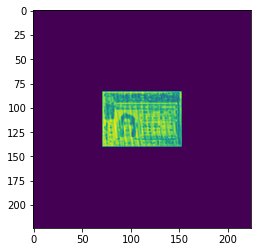

In [4]:
def img_pad(img, downscale):
    downscale = 10+int(8*downscale)
    dimensions = (int(img.shape[1]/downscale), int(img.shape[0]/downscale))
    img_ = cv.resize(img, dimensions)
    pad_to_224_x = int((224 - img_.shape[0])/2)
    pad_to_224_y = int((224 - img_.shape[1])/2)
    img_ = np.pad(img_, ((pad_to_224_x, pad_to_224_x), (pad_to_224_y, pad_to_224_y)), 'constant', constant_values=(0, 0))
    img_ = cv.resize(img_, (224,224))
    return img_
modacaralha = img_pad(naosei, random.random())
plt.imshow(modacaralha)

0.7189679334319581


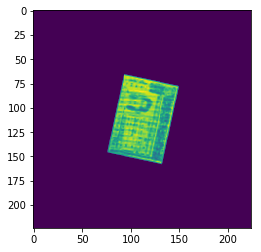

In [5]:
def img_rotate(img, angle):
    num_rows, num_cols = img.shape[:2]
    rotation_matrix = cv.getRotationMatrix2D((num_cols/2, num_rows/2), int(angle*360), 1)
    img_rotation = cv.warpAffine(img, rotation_matrix, (num_cols, num_rows))
    return img_rotation
c = random.random()
modacaralha = img_rotate(modacaralha, c)
plt.imshow(modacaralha)
print(c)

0.6508061160978157 0.3777036257706625


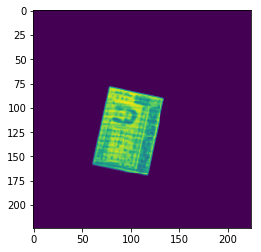

In [6]:
def img_translate(img, a, b):
    rows,cols = img.shape
    M = np.float32([[1,0, 50 - a*100],[0,1, 50 - b*100]])
    img_ = cv.warpAffine(img,M,(cols,rows))
    return img_
a, b = random.random(), random.random()
modacaralha = img_translate(modacaralha, a, b)
plt.imshow(modacaralha)
print(a, b)

In [7]:
def create_batch(img, size):
    batch_x, batch_y = [], []
    for i in range(size):
        img_padded = img_pad(img, random.random())
        rotation_val = random.random()
        translate_a = random.random()
        translate_b = random.random()
        rotated_img = img_rotate(img_padded, rotation_val)
        translated_img = img_translate(rotated_img, translate_a, translate_b)
        batch_x.append(translated_img.ravel())
        batch_y.append([rotation_val, translate_a, translate_b])
    return batch_x, batch_y

In [8]:
from tensorflow.contrib import slim

In [9]:
COLOR_CHANNELS = 1
data_ph = tf.placeholder(tf.float32, shape=[None, COLOR_CHANNELS*224**2])
output_ph = tf.placeholder(tf.float32, shape=[None, 3])
learning_rate = tf.placeholder('float', [])

In [10]:
def alexNet_convolutions(x_image):
    hl = tf.layers.batch_normalization(slim.conv2d(x_image, 32, [11,11], stride=4))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [5,5]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 128, [3, 3]))
    print(hl.shape)
    hl = tf.layers.batch_normalization(slim.conv2d(hl, 86, [3, 3]))
    print(hl.shape)
    hl = slim.max_pool2d(hl, [3,3], stride=2)
    print(hl.shape)
    
    return hl

In [11]:
x_image = tf.reshape(tf.layers.batch_normalization(data_ph), [-1, 224, 224, COLOR_CHANNELS])
hl = alexNet_convolutions(x_image)
hl = slim.flatten(tf.sigmoid(hl))
print(hl.shape)

(?, 56, 56, 32)
(?, 27, 27, 32)
(?, 27, 27, 86)
(?, 13, 13, 86)
(?, 13, 13, 128)
(?, 13, 13, 128)
(?, 13, 13, 86)
(?, 6, 6, 86)
(?, 3096)


In [12]:
fc = slim.stack(hl, slim.fully_connected, [3096, 1569, 564, 84, 3])
print(fc.shape)

(?, 3)


In [13]:
loss = tf.reduce_mean((fc - output_ph)**2)
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [14]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

<IPython.core.display.Javascript object>


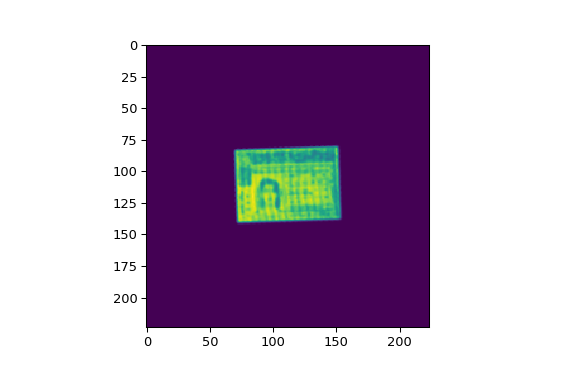

0
0.403794
[[ 0.35555458  0.          0.02023258]]
100
0.0250793
[[ 0.52688712  0.69670576  0.41144118]]
200
0.0156914
[[ 0.57191181  0.67826039  0.4585152 ]]
300
0.055115
[[ 0.55161566  0.74736404  0.40480039]]
400
0.023828
[[ 0.6714195   0.7395584   0.44332856]]
500
0.0209793
[[ 0.7350688   0.68874633  0.50570124]]
600
0.0202368
[[ 0.43437216  0.60767823  0.48145452]]
700
0.00324372
[[ 0.52334154  0.6524241   0.42356235]]
800
0.0211699
[[ 0.65037048  0.64668155  0.34463996]]
900
0.0194711
[[ 0.60413474  0.62773228  0.47232774]]
1000
0.0257856
[[ 0.53745633  0.6204744   0.35129914]]
1100
0.0168879
[[ 0.67871219  0.63867676  0.44913402]]
1200
0.0251444
[[ 0.62871641  0.59672481  0.45664707]]
1300
0.0153265
[[ 0.75768298  0.6275422   0.46000215]]
1400
0.00452918
[[ 0.29518607  0.6463474   0.4873859 ]]
1500
0.044083
[[ 0.6762042   0.63818693  0.4793199 ]]
1600
0.0102036
[[ 0.69046229  0.71502542  0.41245076]]
1700
0.0180666
[[ 0.69930041  0.63294506  0.36443007]]
1800
0.0597138
[[ 0.8322

14700
0.0016266
[[ 0.71436173  0.60684925  0.36009559]]
14800
0.00102046
[[ 0.77869731  0.6018815   0.3271974 ]]
14900
0.00231237
[[ 0.79921204  0.6057747   0.34324351]]
15000
0.00603476
[[ 0.81048208  0.62552518  0.36734855]]
15100
0.00527352
[[ 0.6480273   0.62538207  0.34100789]]
15200
0.00133284
[[ 0.74009526  0.55386525  0.36458144]]
15300
0.0013415
[[ 0.58015072  0.6210658   0.32344672]]
15400
0.00127683
[[ 0.72942144  0.63180226  0.35844696]]
15500
0.00374878
[[ 0.72907466  0.61500281  0.32016516]]
15600
0.00216332
[[ 0.72913831  0.63980275  0.37139213]]
15700
0.00628895
[[ 0.81056404  0.58598548  0.35328302]]
15800
0.0014875
[[ 0.70077109  0.64049387  0.38381234]]
15900
0.00212646
[[ 0.76391959  0.61360931  0.33869892]]
16000
0.002478
[[ 0.75030977  0.61373866  0.35254464]]
16100
0.00233334
[[ 0.76406604  0.60603267  0.35847375]]
16200
0.00382973
[[ 0.88918835  0.63001239  0.35729221]]
16300
0.00342305
[[ 0.80679488  0.61789501  0.32175907]]
16400
0.0126351
[[ 0.75068337  0.624

29100
0.00418427
[[ 0.72599626  0.61577153  0.32737041]]
29200
0.00198141
[[ 0.68815237  0.61864358  0.33974004]]
29300
0.00453565
[[ 0.64499456  0.61443937  0.35845268]]
29400
0.00155154
[[ 0.74715906  0.62158805  0.37071282]]
29500
0.00262902
[[ 0.78464544  0.5969038   0.33071589]]
29600
0.000634672
[[ 0.67762822  0.64588803  0.34053004]]
29700
0.0013232
[[ 0.71252632  0.633183    0.34344763]]
29800
0.0240989
[[ 0.79031253  0.59460318  0.35218015]]
29900
0.000539267
[[ 0.72566295  0.62954938  0.36983758]]
30000
0.00197348
[[ 0.64008749  0.62864757  0.36443594]]
30100
0.00158187
[[ 0.80049652  0.61225969  0.33958116]]
30200
0.00135339
[[ 0.78869992  0.62736732  0.33934629]]
30300
0.000850356
[[ 0.75029415  0.59035015  0.34346876]]
30400
0.000716854
[[ 0.69094342  0.61077619  0.37413171]]
30500
0.00123972
[[ 0.77868026  0.60601473  0.32871822]]
30600
0.00115224
[[ 0.75309455  0.63546735  0.3458156 ]]
30700
0.00120698
[[ 0.74044281  0.62708163  0.36738491]]
30800
0.000654926
[[ 0.716086

43500
0.00143412
[[ 0.69914573  0.66192079  0.38891897]]
43600
0.00110576
[[ 0.67587095  0.60888934  0.39637664]]
43700
0.00095069
[[ 0.65493089  0.61747372  0.37382546]]
43800
0.000964206
[[ 0.62387854  0.65104324  0.38232306]]
43900
0.00291732
[[ 0.73054087  0.62263155  0.40662968]]
44000
0.000834247
[[ 0.76281857  0.63017994  0.35825917]]
44100
0.000215731
[[ 0.77985841  0.63384277  0.3645834 ]]
44200
0.00221834
[[ 0.71862304  0.65613645  0.37482956]]
44300
0.000751394
[[ 0.7829423   0.6255607   0.36553353]]
44400
0.000769956
[[ 0.70268738  0.63579476  0.381125  ]]
44500
0.00042652
[[ 0.72672158  0.63563704  0.38555947]]
44600
0.000760737
[[ 0.7585156   0.61533248  0.36501685]]
44700
0.00377204
[[ 0.78036231  0.60024923  0.38865429]]
44800
0.00392378
[[ 0.68654871  0.64612651  0.40004528]]
44900
0.000624693
[[ 0.69444847  0.63512444  0.36656222]]
45000
0.00075759
[[ 0.74447674  0.62449437  0.37507856]]
45100
0.0020356
[[ 0.65036529  0.64371109  0.38550177]]
45200
0.001795
[[ 0.80087

57800
0.000509047
[[ 0.75351137  0.64754504  0.35638142]]
57900
0.000243689
[[ 0.76180798  0.66036224  0.37656954]]
58000
0.000485677
[[ 0.73219711  0.64635354  0.33736455]]
58100
0.000405394
[[ 0.78530604  0.66334945  0.36512786]]
58200
0.00177271
[[ 0.75607944  0.66464752  0.39369252]]
58300
0.000810885
[[ 0.72228992  0.64862967  0.35864577]]
58400
0.000417423
[[ 0.73231328  0.6568957   0.3770934 ]]
58500
0.000330344
[[ 0.71067959  0.65061963  0.37056488]]
58600
0.000839567
[[ 0.76618046  0.66107029  0.36726621]]
58700
0.000994814
[[ 0.67251992  0.65619332  0.37671277]]
58800
0.00974011
[[ 0.71846229  0.63338393  0.3728742 ]]
58900
0.00083448
[[ 0.76850647  0.64932251  0.37932855]]
59000
0.000948346
[[ 0.72585291  0.67958534  0.37208277]]
59100
9.81807e-05
[[ 0.69646633  0.66511047  0.38234484]]
59200
0.000528248
[[ 0.69786638  0.66625917  0.38291961]]
59300
0.000390206
[[ 0.70712012  0.65780288  0.35720164]]
59400
0.00662334
[[ 0.68584114  0.65576112  0.38524264]]
59500
0.000810377


72100
0.00073459
[[ 0.69784278  0.64556742  0.38822365]]
72200
0.0019738
[[ 0.71404445  0.63585877  0.39038697]]
72300
0.00189956
[[ 0.73854733  0.61742187  0.37091869]]
72400
0.000299468
[[ 0.70885766  0.65239882  0.38605788]]
72500
0.000278788
[[ 0.73815149  0.64890063  0.39214119]]
72600
0.000477776
[[ 0.70970905  0.62077242  0.37469581]]
72700
0.000263541
[[ 0.72107315  0.64632946  0.37409565]]
72800
0.000440579
[[ 0.71611983  0.62763155  0.38128397]]
72900
0.000273486
[[ 0.74163264  0.64937693  0.39859742]]
73000
0.00060138
[[ 0.72418427  0.64751333  0.3917838 ]]
73100
0.000427502
[[ 0.69065559  0.64067149  0.37213209]]
73200
0.000556389
[[ 0.72620022  0.62874156  0.39212608]]
73300
0.00037433
[[ 0.72960347  0.64265466  0.37691036]]
73400
0.00223443
[[ 0.72241062  0.65706676  0.3798269 ]]
73500
0.000659349
[[ 0.72278249  0.63822955  0.3766315 ]]
73600
0.00151816
[[ 0.75349849  0.67567706  0.37621599]]
73700
0.000619682
[[ 0.70482224  0.65948802  0.3993443 ]]
73800
0.00127247
[[ 0.

86400
0.000616633
[[ 0.69754332  0.63422716  0.38339013]]
86500
0.000339815
[[ 0.71712178  0.64173275  0.39048916]]
86600
0.000196037
[[ 0.72293448  0.64448702  0.39420205]]
86700
0.000403061
[[ 0.69710839  0.65891564  0.36960334]]
86800
0.00147396
[[ 0.7318477   0.65334731  0.40695965]]
86900
0.00440301
[[ 0.71646756  0.62063187  0.37846515]]
87000
0.000649053
[[ 0.71080548  0.63120002  0.40212753]]
87100
0.000283863
[[ 0.73232669  0.63626742  0.38586795]]
87200
0.00137292
[[ 0.74600875  0.64689112  0.39415121]]
87300
0.000127452
[[ 0.66906244  0.64671576  0.38364977]]
87400
0.00333129
[[ 0.72323173  0.62603647  0.42105201]]
87500
0.000700192
[[ 0.71602529  0.64154202  0.41137898]]
87600
0.00020368
[[ 0.72187364  0.66539586  0.38976687]]
87700
0.00104473
[[ 0.7018016   0.64449233  0.38615221]]
87800
0.000705472
[[ 0.68201673  0.64406109  0.37928447]]
87900
0.00048404
[[ 0.7194947   0.63751549  0.416958  ]]
88000
0.00054307
[[ 0.72025621  0.64697278  0.40052581]]
88100
0.00146231
[[ 0.

100700
0.000507136
[[ 0.71124583  0.64933872  0.38810804]]
100800
0.000315829
[[ 0.70743394  0.6363126   0.39391667]]
100900
0.000648921
[[ 0.70978999  0.63899118  0.3837049 ]]
101000
0.000520694
[[ 0.73096442  0.65400732  0.37035811]]
101100
0.000347105
[[ 0.71354163  0.6567952   0.36235231]]
101200
0.000789766
[[ 0.71849042  0.64233154  0.36668897]]
101300
0.000167575
[[ 0.69057465  0.63437706  0.36107504]]
101400
0.000592766
[[ 0.69701713  0.65654719  0.36892292]]
101500
0.000213691
[[ 0.68423909  0.64836609  0.36183783]]
101600
0.000866253
[[ 0.69056505  0.64560109  0.37593153]]
101700
0.00475679
[[ 0.75571698  0.66195756  0.38049641]]
101800
0.000172427
[[ 0.70668948  0.65016812  0.36820251]]
101900
0.00013704
[[ 0.74637097  0.64389127  0.38349167]]
102000
0.001719
[[ 0.68403035  0.63832617  0.39281479]]
102100
0.00052146
[[ 0.72572047  0.62476605  0.36010316]]
102200
0.00041417
[[ 0.73914695  0.63425153  0.37510026]]
102300
0.00045401
[[ 0.71266651  0.63520503  0.3612051 ]]
10240

114700
0.000262191
[[ 0.71090883  0.63656455  0.3974317 ]]
114800
0.000597616
[[ 0.70500016  0.64400673  0.35978118]]
114900
0.000348421
[[ 0.74693084  0.63331264  0.38450295]]
115000
0.000298915
[[ 0.72942019  0.63407117  0.37837797]]
115100
0.000416135
[[ 0.69648963  0.63119704  0.37967202]]
115200
0.000452964
[[ 0.71698403  0.64028138  0.3583855 ]]
115300
0.000308506
[[ 0.72964555  0.63074696  0.38083982]]
115400
0.00079538
[[ 0.72362328  0.65026438  0.36085147]]
115500
0.00342864
[[ 0.63844866  0.65385926  0.37988725]]
115600
0.000559196
[[ 0.6792143   0.64047551  0.3790938 ]]
115700
0.000558339
[[ 0.71674776  0.65227431  0.39918616]]
115800
0.000274005
[[ 0.71364617  0.62287533  0.37555596]]
115900
0.000529103
[[ 0.69975388  0.63105273  0.38128084]]
116000
0.000245221
[[ 0.72008562  0.64101404  0.38416362]]
116100
0.000788983
[[ 0.69086838  0.62626988  0.35776713]]
116200
0.00019581
[[ 0.70958155  0.63125521  0.39444116]]
116300
0.000268213
[[ 0.71190071  0.62630999  0.37896138]]


128700
0.000233408
[[ 0.70552254  0.64875585  0.36828911]]
128800
0.00229261
[[ 0.60561031  0.64066619  0.3808389 ]]
128900
0.00233702
[[ 0.64682937  0.60972327  0.39021957]]
129000
0.0189095
[[ 0.71947944  0.64425242  0.36819255]]
129100
0.000849389
[[ 0.71138066  0.64761269  0.38447317]]
129200
0.000241174
[[ 0.67711812  0.67278451  0.36053127]]
129300
0.00111886
[[ 0.72500962  0.64533311  0.38129032]]
129400
0.000247596
[[ 0.70996195  0.64783484  0.38394585]]
129500
0.000382293
[[ 0.71443188  0.64915794  0.37901157]]
129600
0.000489045
[[ 0.70669174  0.66324019  0.37787566]]
129700
0.000430293
[[ 0.7196461   0.65262383  0.38796055]]
129800
0.000295227
[[ 0.69717026  0.64030737  0.36684519]]
129900
0.000191972
[[ 0.69846982  0.64271665  0.37403613]]
130000
0.000190218
[[ 0.69724202  0.63777465  0.37656927]]
130100
0.000485238
[[ 0.71215689  0.64829206  0.38754129]]
130200
0.000199629
[[ 0.69869852  0.64542729  0.38786322]]
130300
0.000315446
[[ 0.66378063  0.65830612  0.36779711]]
13

142700
0.000433201
[[ 0.70486993  0.65853083  0.40123332]]
142800
0.00115246
[[ 0.6800698   0.60963142  0.40692937]]
142900
0.000597992
[[ 0.71841657  0.64077181  0.37482306]]
143000
0.000403971
[[ 0.71797764  0.64414042  0.39003283]]
143100
0.000385025
[[ 0.74423313  0.63741046  0.36710298]]
143200
0.000419297
[[ 0.72023016  0.64239544  0.38944808]]
143300
0.000625974
[[ 0.71413612  0.63329524  0.39425397]]
143400
0.00261231
[[ 0.72470158  0.64817876  0.3875021 ]]
143500
0.000561032
[[ 0.69986093  0.62521487  0.38141233]]
143600
0.00120352
[[ 0.72561175  0.63061571  0.3808631 ]]
143700
0.000195445
[[ 0.71828914  0.63846362  0.39114037]]
143800
0.000193733
[[ 0.71033061  0.64845461  0.39126465]]
143900
0.000483687
[[ 0.70671034  0.63450092  0.37619516]]
144000
9.3396e-05
[[ 0.70750153  0.65412492  0.39039099]]
144100
0.000388519
[[ 0.71012211  0.62620139  0.38724551]]
144200
0.000742728
[[ 0.70483536  0.63832009  0.38444346]]
144300
0.000346832
[[ 0.69087577  0.6379813   0.38463077]]
1

156700
0.000802345
[[ 0.68644333  0.64059961  0.35964441]]
156800
0.00030013
[[ 0.70392483  0.64435154  0.35210246]]
156900
0.000515733
[[ 0.68613875  0.64449692  0.3504757 ]]
157000
0.00464069
[[ 0.76613951  0.6719383   0.33828744]]
157100
0.000484794
[[ 0.66276073  0.6580714   0.35925129]]
157200
8.39734e-05
[[ 0.68561679  0.64893425  0.35750702]]
157300
0.000143772
[[ 0.68628323  0.63946319  0.37313136]]
157400
0.000740226
[[ 0.68014407  0.63985008  0.36852878]]
157500
0.000231002
[[ 0.69458967  0.64332902  0.38531744]]
157600
0.000165638
[[ 0.69764245  0.64563245  0.37234631]]
157700
0.000104385
[[ 0.69966853  0.64393717  0.37317148]]
157800
0.000137108
[[ 0.69811785  0.63609928  0.3574031 ]]
157900
0.00064065
[[ 0.72724444  0.63436669  0.37696725]]
158000
0.000289129
[[ 0.71632695  0.64178944  0.37689719]]
158100
0.000122017
[[ 0.6902653   0.649791    0.37732384]]
158200
0.000136649
[[ 0.69563282  0.64519483  0.37429711]]
158300
0.000350854
[[ 0.70168632  0.64124173  0.36657512]]


170700
8.50248e-05
[[ 0.69365251  0.63075346  0.37971336]]
170800
0.00253267
[[ 0.68422145  0.63284385  0.38311535]]
170900
0.00180515
[[ 0.73398089  0.63606435  0.37524706]]
171000
0.000754053
[[ 0.72967511  0.64077038  0.37471026]]
171100
3.22923e-05
[[ 0.68745351  0.63431865  0.36468077]]
171200
0.000502648
[[ 0.73087054  0.63520163  0.36397034]]
171300
0.000347068
[[ 0.70382404  0.63470566  0.36509702]]
171400
0.00012261
[[ 0.69454712  0.65161771  0.36904621]]
171500
0.00117093
[[ 0.70187724  0.63248152  0.36246127]]
171600
0.00140246
[[ 0.74213022  0.63497287  0.37999257]]
171700
0.000783312
[[ 0.66364634  0.65385854  0.3638238 ]]
171800
0.000659876
[[ 0.69922954  0.63475448  0.37444273]]
171900
0.000307618
[[ 0.71752012  0.64319766  0.38574162]]
172000
0.000136332
[[ 0.71696413  0.64137769  0.36923927]]
172100
0.000305599
[[ 0.72589421  0.62981343  0.37781411]]
172200
0.000776197
[[ 0.70098388  0.63607633  0.37526798]]
172300
0.000143093
[[ 0.71910578  0.64726007  0.37656903]]
17

184700
0.000319614
[[ 0.72116709  0.64531231  0.38511404]]
184800
0.00026156
[[ 0.72473091  0.63770676  0.3706885 ]]
184900
0.000797675
[[ 0.69791305  0.62820905  0.36668649]]
185000
0.000927273
[[ 0.74323291  0.63171434  0.37732989]]
185100
0.000291072
[[ 0.74934435  0.6337285   0.37390643]]
185200
0.000198629
[[ 0.69791698  0.6387623   0.37571472]]
185300
7.53796e-05
[[ 0.70119935  0.64871311  0.37209052]]
185400
0.000837336
[[ 0.68138242  0.63030511  0.38316545]]
185500
0.0006133
[[ 0.70871919  0.63268512  0.37513039]]
185600
0.000356186
[[ 0.72527355  0.63697541  0.36716655]]
185700
0.000689941
[[ 0.72328514  0.64372557  0.36612394]]
185800
0.00298256
[[ 0.71067345  0.64387488  0.37831384]]
185900
0.000702767
[[ 0.7177465   0.62578249  0.36270609]]
186000
0.000185894
[[ 0.69960088  0.64439029  0.37507817]]
186100
0.000264162
[[ 0.70165563  0.62473983  0.37342152]]
186200
0.000421712
[[ 0.70364571  0.64069581  0.38391361]]
186300
0.000336739
[[ 0.71581364  0.64461946  0.37857509]]
1

198700
0.000424892
[[ 0.69980836  0.64433253  0.40234211]]
198800
0.000133838
[[ 0.70754617  0.64180636  0.38326639]]
198900
7.20268e-05
[[ 0.71485877  0.62502629  0.3854284 ]]
199000
0.000279426
[[ 0.69058478  0.64811909  0.38688499]]
199100
0.000168051
[[ 0.71966958  0.64482075  0.40284526]]
199200
0.00019652
[[ 0.72352368  0.64205158  0.39283848]]
199300
0.000193717
[[ 0.76569259  0.63238138  0.38843927]]
199400
9.09376e-05
[[ 0.73161793  0.63209337  0.39226314]]
199500
0.000193576
[[ 0.71245122  0.65241188  0.39309633]]
199600
0.000249647
[[ 0.70126206  0.65433311  0.37242183]]
199700
0.000263826
[[ 0.72146368  0.65034956  0.38649222]]
199800
0.000119751
[[ 0.7121886   0.65440053  0.38351634]]
199900
0.000138381
[[ 0.70925981  0.63798684  0.38320777]]
200000
0.000349761
[[ 0.71315324  0.62108648  0.3921918 ]]
200100
0.00219136
[[ 0.73890042  0.63378924  0.36250892]]
200200
0.000852912
[[ 0.72213602  0.63915336  0.37869483]]
200300
0.000126993
[[ 0.72672153  0.64188206  0.39727321]]

212700
0.000259384
[[ 0.72015953  0.64600956  0.36732817]]
212800
9.35703e-05
[[ 0.7129975   0.64898586  0.37720469]]
212900
0.000818529
[[ 0.62513512  0.64745367  0.373613  ]]
213000
0.000141025
[[ 0.6914227   0.64663142  0.38057539]]
213100
0.000124445
[[ 0.69467825  0.64511502  0.37444693]]
213200
0.000106944
[[ 0.68210304  0.6617527   0.38721728]]
213300
0.000138222
[[ 0.70111305  0.65113103  0.38163632]]
213400
8.77759e-05
[[ 0.68210185  0.64056247  0.37761927]]
213500
0.000189123
[[ 0.70374089  0.64650631  0.39153954]]
213600
0.000127334
[[ 0.70236558  0.65761709  0.39360857]]
213700
0.000118481
[[ 0.69384378  0.66127801  0.39597487]]
213800
0.000228043
[[ 0.70356172  0.66373551  0.38791999]]
213900
0.00185791
[[ 0.63995308  0.65691411  0.38326183]]
214000
0.000688409
[[ 0.70945334  0.64052218  0.38761368]]
214100
0.0135413
[[ 0.76590067  0.63712895  0.35258672]]
214200
0.000212532
[[ 0.71806926  0.64790899  0.37596518]]
214300
0.000233699
[[ 0.74091548  0.62923032  0.37983415]]


226700
0.00021543
[[ 0.74251193  0.64499891  0.38673833]]
226800
0.000310351
[[ 0.6906206   0.62719566  0.36210603]]
226900
0.00383093
[[ 0.73438466  0.63655251  0.38763237]]
227000
9.92744e-05
[[ 0.71435523  0.64304096  0.36552736]]
227100
0.000135668
[[ 0.72772241  0.63486648  0.37222216]]
227200
0.00133567
[[ 0.63378489  0.64150763  0.3647112 ]]
227300
0.00010641
[[ 0.70801854  0.63702047  0.36284503]]
227400
0.000109776
[[ 0.72110891  0.63391984  0.37719521]]
227500
0.000398597
[[ 0.68265003  0.6507265   0.36824524]]
227600
0.000272282
[[ 0.69853008  0.63698     0.36281687]]
227700
0.00040159
[[ 0.69541866  0.64282817  0.37516043]]
227800
0.000127641
[[ 0.68754667  0.63778001  0.37271234]]
227900
0.000178349
[[ 0.69806701  0.63536108  0.37744606]]
228000
0.000242627
[[ 0.7171061   0.63493276  0.37333241]]
228100
0.000353823
[[ 0.69855922  0.63997364  0.38892534]]
228200
0.000208336
[[ 0.71120983  0.65310597  0.40252176]]
228300
9.45832e-05
[[ 0.69743109  0.62490463  0.3796275 ]]
22

240700
0.000137493
[[ 0.7254343   0.63822526  0.36578682]]
240800
0.000320952
[[ 0.71691328  0.64654851  0.37922364]]
240900
6.08683e-05
[[ 0.71673852  0.64708209  0.37353101]]
241000
0.000328788
[[ 0.70278007  0.64402318  0.38109106]]
241100
0.000142279
[[ 0.71970475  0.63740206  0.36257911]]
241200
8.07672e-05
[[ 0.71885794  0.63427186  0.37209344]]
241300
5.64916e-05
[[ 0.70439494  0.6357888   0.3793062 ]]
241400
0.000123295
[[ 0.7068004   0.64174986  0.38861334]]
241500
6.60988e-05
[[ 0.7034632   0.64020532  0.37690663]]
241600
6.12616e-05
[[ 0.70941257  0.64931178  0.38374603]]
241700
0.00156447
[[ 0.79613316  0.65515202  0.3734175 ]]
241800
0.000350193
[[ 0.70521402  0.64484024  0.36425617]]
241900
0.000295667
[[ 0.68858987  0.64904279  0.36466721]]
242000
0.000276431
[[ 0.70478052  0.64439368  0.38037926]]
242100
0.000941208
[[ 0.72366309  0.64487076  0.37812346]]
242200
0.000384319
[[ 0.70709032  0.63968885  0.386857  ]]
242300
0.00181035
[[ 0.74969965  0.64738566  0.36253431]]

254700
0.000114396
[[ 0.7121799   0.63155091  0.37933129]]
254800
0.000289168
[[ 0.71673411  0.64625412  0.38428998]]
254900
0.000857454
[[ 0.70784014  0.64989895  0.38161081]]
255000
0.000254025
[[ 0.71567941  0.64311504  0.36892247]]
255100
0.000152541
[[ 0.71282113  0.63303512  0.37137038]]
255200
0.000108879
[[ 0.70670491  0.64007795  0.37087134]]
255300
6.44467e-05
[[ 0.71146446  0.63647127  0.37747014]]
255400
0.000314471
[[ 0.69879085  0.63816059  0.37170976]]
255500
0.000210075
[[ 0.71796095  0.64628994  0.36806875]]
255600
4.57999e-05
[[ 0.73449761  0.63753879  0.37293547]]
255700
9.26646e-05
[[ 0.71699798  0.63543177  0.36069188]]
255800
6.83474e-05
[[ 0.74434453  0.64527071  0.3711448 ]]
255900
0.00312271
[[ 0.71156555  0.65252751  0.37611821]]
256000
0.000246304
[[ 0.72564149  0.65677106  0.39137414]]
256100
0.000640281
[[ 0.66754204  0.64753401  0.37015894]]
256200
0.000380307
[[ 0.70621365  0.62474698  0.37651655]]
256300
0.000181377
[[ 0.71943808  0.64580274  0.36171451]

268700
0.000299855
[[ 0.69341666  0.63608241  0.3749561 ]]
268800
0.000326115
[[ 0.70548356  0.63762528  0.37654954]]
268900
8.85277e-05
[[ 0.71837175  0.6382966   0.37308785]]
269000
0.000318718
[[ 0.70974451  0.63346171  0.37704596]]
269100
0.000424691
[[ 0.71613079  0.64373159  0.35940412]]
269200
0.000198882
[[ 0.711339    0.64105499  0.35750318]]
269300
0.000298792
[[ 0.71874809  0.64077437  0.36166993]]
269400
0.000155625
[[ 0.71863788  0.64238602  0.36792263]]
269500
0.000173675
[[ 0.71220368  0.6461603   0.36412841]]
269600
0.0001757
[[ 0.70711964  0.63507611  0.36850023]]
269700
0.000229479
[[ 0.70393825  0.65839076  0.37775576]]
269800
0.000742342
[[ 0.69722444  0.65034759  0.36288515]]
269900
0.000110545
[[ 0.70918536  0.65702009  0.37437046]]
270000
0.00019543
[[ 0.70527261  0.65169233  0.36231232]]
270100
4.9414e-05
[[ 0.70226264  0.66283011  0.37128946]]
270200
8.18995e-05
[[ 0.70308393  0.65574425  0.38119778]]
270300
0.000476684
[[ 0.70381451  0.66201842  0.37234327]]
2

282700
0.000230962
[[ 0.72471189  0.6523273   0.37049925]]
282800
0.000206088
[[ 0.70387012  0.63568282  0.3757554 ]]
282900
0.000150865
[[ 0.73162121  0.65677524  0.35820594]]
283000
0.000203953
[[ 0.71006745  0.63825613  0.35472068]]
283100
9.2685e-05
[[ 0.72422028  0.64263886  0.37846053]]
283200
0.000199336
[[ 0.68168026  0.64889151  0.36649442]]
283300
0.000141744
[[ 0.71211028  0.65295154  0.36974403]]
283400
7.35816e-05
[[ 0.71879858  0.64977902  0.37561333]]
283500
0.000139035
[[ 0.71312797  0.65376705  0.37223065]]
283600
0.000154838
[[ 0.68915516  0.65537971  0.37079597]]
283700
0.000343789
[[ 0.71354532  0.65567964  0.37837079]]
283800
0.000117395
[[ 0.73760951  0.6527546   0.37398779]]
283900
0.000103268
[[ 0.70755225  0.65539753  0.36822918]]
284000
0.00033428
[[ 0.70305264  0.63140255  0.3680031 ]]
284100
0.000126557
[[ 0.69045532  0.64231414  0.38468185]]
284200
0.000173456
[[ 0.68854362  0.64638472  0.37077478]]
284300
0.000447802
[[ 0.7023136   0.64757979  0.37100217]]

296700
5.4266e-05
[[ 0.7051487   0.64929152  0.38806263]]
296800
7.68203e-05
[[ 0.69988996  0.62899226  0.38238463]]
296900
0.000229438
[[ 0.70882756  0.6375863   0.38039479]]
297000
0.000142812
[[ 0.70742875  0.63742447  0.38451543]]
297100
0.00017046
[[ 0.72813606  0.64064348  0.38289374]]
297200
6.89747e-05
[[ 0.71374094  0.63522369  0.38463619]]
297300
5.47509e-05
[[ 0.73771554  0.63485152  0.38601884]]
297400
0.000111542
[[ 0.70189166  0.64898401  0.36513832]]
297500
0.000209944
[[ 0.69651991  0.63979971  0.3717083 ]]
297600
0.00018464
[[ 0.64875096  0.64633596  0.40140614]]
297700
0.000146416
[[ 0.69583249  0.64151984  0.38541093]]
297800
0.000151182
[[ 0.68272233  0.64218605  0.39298227]]
297900
0.000372865
[[ 0.6987856   0.64353234  0.38639334]]
298000
0.000220907
[[ 0.69250464  0.64869547  0.38729334]]
298100
4.90467e-05
[[ 0.6946134   0.65282589  0.37526387]]
298200
8.35363e-05
[[ 0.71088487  0.65363783  0.38257676]]
298300
7.77478e-05
[[ 0.7017749   0.64972717  0.38112512]]


310700
0.000101341
[[ 0.69215739  0.64343768  0.36838096]]
310800
5.82863e-05
[[ 0.70498574  0.63074517  0.37240779]]
310900
0.00016514
[[ 0.71360815  0.65045983  0.38107607]]
311000
0.000245137
[[ 0.70419097  0.64341539  0.38208845]]
311100
0.00020399
[[ 0.7055974   0.65311664  0.37242025]]
311200
0.000209613
[[ 0.70831585  0.64552885  0.3787674 ]]
311300
0.000110199
[[ 0.70522213  0.65013045  0.38467568]]
311400
0.000110909
[[ 0.70578307  0.64825082  0.36915186]]
311500
0.000109478
[[ 0.70315534  0.64337754  0.36595562]]
311600
0.000158499
[[ 0.69985998  0.64725053  0.38167801]]
311700
0.000298239
[[ 0.73903233  0.64037824  0.3841587 ]]
311800
0.000137774
[[ 0.70357502  0.64281213  0.38299677]]
311900
8.06394e-05
[[ 0.69905937  0.64973933  0.37106052]]
312000
7.83191e-05
[[ 0.69217366  0.64991558  0.37275201]]
312100
0.000160936
[[ 0.69110376  0.65775871  0.36600822]]
312200
0.000114584
[[ 0.7001037   0.66015619  0.38506779]]
312300
0.000176146
[[ 0.71438062  0.65321195  0.37582037]]

324700
0.000432013
[[ 0.70971197  0.63333452  0.38046867]]
324800
0.000287625
[[ 0.71885514  0.63859576  0.371959  ]]
324900
9.5033e-05
[[ 0.7165693   0.63730854  0.36665067]]
325000
0.000149461
[[ 0.69617045  0.63436502  0.36743519]]
325100
0.000119129
[[ 0.7092821   0.64376229  0.37792766]]
325200
0.000428356
[[ 0.70688784  0.64651734  0.38885444]]
325300
0.0190573
[[ 0.68389374  0.64357817  0.368983  ]]
325400
0.000164106
[[ 0.71828449  0.64332074  0.3605302 ]]
325500
5.34159e-05
[[ 0.70347083  0.64757288  0.37775278]]
325600
0.00028093
[[ 0.69531417  0.63277125  0.37337264]]
325700
4.86992e-05
[[ 0.70156568  0.63101387  0.36913323]]
325800
9.15732e-05
[[ 0.70319277  0.64223158  0.37793961]]
325900
7.63149e-05
[[ 0.69771761  0.63978797  0.3848528 ]]
326000
0.000233307
[[ 0.71440369  0.64037246  0.3741684 ]]
326100
0.000142638
[[ 0.69796246  0.65088332  0.38226143]]
326200
0.000407267
[[ 0.69275063  0.64658809  0.37931821]]
326300
0.000399582
[[ 0.73299223  0.64787     0.37047666]]
3

338700
0.000221909
[[ 0.71556091  0.66094494  0.37280074]]
338800
0.000681765
[[ 0.65990794  0.66290826  0.40530828]]
338900
0.00015667
[[ 0.70188707  0.6615178   0.38706198]]
339000
0.000592334
[[ 0.73867506  0.65125668  0.37438816]]
339100
0.000267578
[[ 0.69685578  0.65137404  0.3705138 ]]
339200
0.000158142
[[ 0.70071769  0.64761734  0.36657771]]
339300
8.4005e-05
[[ 0.70691115  0.65696859  0.38845137]]
339400
9.91095e-05
[[ 0.7049799   0.64934099  0.37964395]]
339500
0.000170555
[[ 0.70397878  0.63359869  0.38479039]]
339600
0.000305076
[[ 0.71657306  0.65804666  0.37945795]]
339700
5.7049e-05
[[ 0.70920169  0.65288848  0.37324262]]
339800
0.000153103
[[ 0.72621441  0.65279651  0.38399976]]
339900
0.000149423
[[ 0.71233869  0.64491385  0.37628728]]
340000
0.00010471
[[ 0.71495926  0.6534574   0.37330148]]
340100
0.000118927
[[ 0.72550386  0.65008503  0.3796967 ]]
340200
3.48589e-05
[[ 0.71705586  0.6406908   0.37313974]]
340300
8.99291e-05
[[ 0.70346153  0.64874756  0.37138173]]
3

352700
0.00010105
[[ 0.70096016  0.64239919  0.38121545]]
352800
0.000126285
[[ 0.69603729  0.64141607  0.38054022]]
352900
7.25554e-05
[[ 0.72228295  0.64142358  0.38742638]]
353000
0.000126384
[[ 0.70877969  0.63646358  0.36958525]]
353100
5.52836e-05
[[ 0.70760131  0.63282758  0.37793353]]
353200
0.000121994
[[ 0.71641445  0.649266    0.36673629]]
353300
7.42517e-05
[[ 0.71381062  0.64741421  0.37692633]]
353400
0.0001408
[[ 0.68681228  0.64243931  0.38207522]]
353500
8.03374e-05
[[ 0.71610427  0.64669317  0.37112388]]
353600
7.84788e-05
[[ 0.71363193  0.64485073  0.36647606]]
353700
9.7391e-05
[[ 0.72159904  0.63974738  0.37627068]]
353800
5.13749e-05
[[ 0.70697802  0.64912719  0.37632391]]
353900
7.28992e-05
[[ 0.72132105  0.65817225  0.38226831]]
354000
0.000104995
[[ 0.71417385  0.64707816  0.37011734]]
354100
6.37185e-05
[[ 0.74104601  0.66138887  0.3692584 ]]
354200
7.12879e-05
[[ 0.71948892  0.64694566  0.36903727]]
354300
0.000256001
[[ 0.72484159  0.65414864  0.37576655]]
3

366700
0.00140101
[[ 0.72412407  0.64794451  0.37704334]]
366800
0.000231574
[[ 0.71201444  0.65016001  0.39527035]]
366900
0.000132102
[[ 0.70474005  0.64926881  0.39608991]]
367000
7.06749e-05
[[ 0.70265847  0.65633923  0.38947579]]
367100
7.24518e-05
[[ 0.72030264  0.65523487  0.39207608]]
367200
8.29242e-05
[[ 0.71491373  0.64547545  0.39379525]]
367300
0.000140752
[[ 0.72061986  0.6517998   0.39595702]]
367400
6.21664e-05
[[ 0.71095628  0.65444255  0.39020348]]
367500
0.000120256
[[ 0.69122636  0.64929223  0.37285763]]
367600
0.000143497
[[ 0.71176803  0.65734321  0.39690343]]
367700
7.49959e-05
[[ 0.71832865  0.65641642  0.37962151]]
367800
0.000480499
[[ 0.75123507  0.65334481  0.38089642]]
367900
0.000526584
[[ 0.71652931  0.65868968  0.37439686]]
368000
6.61728e-05
[[ 0.70724696  0.66149426  0.37269312]]
368100
9.94126e-05
[[ 0.69096839  0.66604382  0.39017951]]
368200
0.00010062
[[ 0.7164405   0.64228529  0.37599218]]
368300
0.000141134
[[ 0.69492483  0.65080756  0.3863678 ]]

380700
0.0051133
[[ 0.6995126   0.64378273  0.37072805]]
380800
0.000413543
[[ 0.70967573  0.64860737  0.37217838]]
380900
0.000113631
[[ 0.70174491  0.64251852  0.37393188]]
381000
0.000168751
[[ 0.711869    0.64744687  0.36840862]]
381100
0.000129413
[[ 0.70427579  0.64219016  0.35901415]]
381200
0.000150097
[[ 0.71496791  0.64594603  0.36569822]]
381300
0.000582473
[[ 0.71787685  0.64396578  0.37496623]]
381400
8.36451e-05
[[ 0.71463615  0.64568722  0.37209636]]
381500
6.94085e-05
[[ 0.71452421  0.6489445   0.37193546]]
381600
0.000102422
[[ 0.70233846  0.65541601  0.37678126]]
381700
4.69016e-05
[[ 0.71222937  0.64180773  0.38091716]]
381800
5.40752e-05
[[ 0.71733505  0.65390742  0.38270381]]
381900
8.52752e-05
[[ 0.71899301  0.64162266  0.37159318]]
382000
6.35746e-05
[[ 0.7030465   0.64040464  0.36380842]]
382100
6.21488e-05
[[ 0.67647874  0.65467209  0.36178157]]
382200
5.46991e-05
[[ 0.71088767  0.6575706   0.37307096]]
382300
0.000108996
[[ 0.72794867  0.63891196  0.36881298]]

394700
0.000255108
[[ 0.70440865  0.65151966  0.37784538]]
394800
6.53746e-05
[[ 0.70699424  0.64789355  0.37800461]]
394900
4.0041e-05
[[ 0.70939112  0.64966339  0.37249351]]
395000
5.98451e-05
[[ 0.70478368  0.64262587  0.37998879]]
395100
0.00011039
[[ 0.7075572   0.64721531  0.37054217]]
395200
0.000114767
[[ 0.70033848  0.63972855  0.37872583]]
395300
0.00194753
[[ 0.70515567  0.65517169  0.37526634]]
395400
9.73498e-05
[[ 0.6793189   0.64932513  0.38098851]]
395500
7.29855e-05
[[ 0.69473922  0.65414137  0.38841525]]
395600
0.00010125
[[ 0.7053569   0.64925754  0.38373467]]
395700
0.000298648
[[ 0.70920396  0.64151984  0.37311909]]
395800
0.000126842
[[ 0.70973849  0.65185016  0.38059598]]
395900
0.000191629
[[ 0.72342265  0.65262222  0.38587821]]
396000
0.000473006
[[ 0.71505916  0.64596152  0.37345341]]
396100
7.41913e-05
[[ 0.69734251  0.65500802  0.37253603]]
396200
0.000217988
[[ 0.71200162  0.64880925  0.36424938]]
396300
0.000139605
[[ 0.70879424  0.64880753  0.38475022]]
3

408700
0.00033063
[[ 0.69436824  0.6585722   0.36957121]]
408800
0.000157362
[[ 0.70095956  0.64554244  0.37697411]]
408900
0.000249973
[[ 0.71044147  0.64009827  0.35851261]]
409000
0.00014623
[[ 0.71075314  0.64295042  0.3744882 ]]
409100
7.99443e-05
[[ 0.70618367  0.64998025  0.37923589]]
409200
2.10697e-05
[[ 0.71221918  0.65535641  0.37116316]]
409300
9.4405e-05
[[ 0.72149193  0.64855075  0.37830725]]
409400
0.000164936
[[ 0.71400684  0.65072328  0.36463025]]
409500
0.000434561
[[ 0.68021899  0.6576407   0.36962897]]
409600
0.000155395
[[ 0.68189961  0.65355861  0.36930135]]
409700
0.000118716
[[ 0.69119656  0.65379763  0.36949593]]
409800
0.000196913
[[ 0.67558819  0.6482141   0.39121601]]
409900
8.16589e-05
[[ 0.69932425  0.64014149  0.38974544]]
410000
0.000278565
[[ 0.69820458  0.64762443  0.37822399]]
410100
0.000132993
[[ 0.72208309  0.63975638  0.37354726]]
410200
5.56019e-05
[[ 0.7101472   0.63478619  0.36316371]]
410300
7.66518e-05
[[ 0.70588547  0.64260674  0.37021521]]


422700
8.34275e-05
[[ 0.71333319  0.65349746  0.37511891]]
422800
0.000228885
[[ 0.73601466  0.6438688   0.37939072]]
422900
0.000122163
[[ 0.71577615  0.64773244  0.38478655]]
423000
9.77195e-05
[[ 0.72132462  0.65197992  0.38087943]]
423100
0.000129637
[[ 0.71962732  0.64596474  0.37380311]]
423200
0.000320147
[[ 0.71311909  0.64926463  0.38696092]]
423300
0.00011881
[[ 0.72681224  0.64215028  0.37638745]]
423400
5.09124e-05
[[ 0.71860641  0.64777189  0.38068593]]
423500
0.000217524
[[ 0.70203716  0.646945    0.37360078]]
423600
7.44372e-05
[[ 0.72252339  0.64209747  0.37044686]]
423700
0.000103547
[[ 0.69153064  0.63642365  0.3938843 ]]
423800
3.75694e-05
[[ 0.71442604  0.6508885   0.39332342]]
423900
0.00582536
[[ 0.72799826  0.66144615  0.36177793]]
424000
0.000150884
[[ 0.71930629  0.64681405  0.38801247]]
424100
0.000104708
[[ 0.70811194  0.64604676  0.3820172 ]]
424200
0.000103831
[[ 0.70549655  0.63874316  0.38244015]]
424300
0.00011673
[[ 0.71099979  0.65119261  0.3846992 ]]


436700
0.000610074
[[ 0.71884227  0.64209902  0.3879512 ]]
436800
0.000208548
[[ 0.71814752  0.64035881  0.38777503]]
436900
2.22324e-05
[[ 0.70824182  0.63863873  0.37803477]]
437000
0.00016055
[[ 0.70378059  0.64402676  0.38535213]]
437100
0.000144758
[[ 0.7080251   0.64328045  0.38339218]]
437200
0.00012133
[[ 0.69553542  0.64853793  0.37740657]]
437300
0.00042247
[[ 0.72097826  0.63649946  0.38213477]]
437400
0.000159957
[[ 0.69664019  0.63422686  0.37285691]]
437500
4.41586e-05
[[ 0.69657099  0.65042162  0.38576853]]
437600
0.000108085
[[ 0.70189959  0.64375764  0.38415048]]
437700
9.87431e-05
[[ 0.69743282  0.6452167   0.38527423]]
437800
5.84884e-05
[[ 0.70319104  0.64795959  0.38544935]]
437900
3.4426e-05
[[ 0.70289397  0.64128548  0.37516248]]
438000
9.91957e-05
[[ 0.70579463  0.64340955  0.38135675]]
438100
5.46128e-05
[[ 0.69319451  0.6417014   0.3812398 ]]
438200
0.000114943
[[ 0.69730318  0.64423513  0.37548092]]
438300
8.14497e-05
[[ 0.69487286  0.63427961  0.3906171 ]]
4

450700
8.71908e-05
[[ 0.71682066  0.64693886  0.38105229]]
450800
0.00042261
[[ 0.73212993  0.6523968   0.38980809]]
450900
0.000300879
[[ 0.70230663  0.63942379  0.39310023]]
451000
0.000152019
[[ 0.71051657  0.65935206  0.39251521]]
451100
0.000108567
[[ 0.71690595  0.64929742  0.39329764]]
451200
0.00020507
[[ 0.67973661  0.65785015  0.38088596]]
451300
0.000150846
[[ 0.70807856  0.65486842  0.39079368]]
451400
8.75578e-05
[[ 0.71872336  0.65498531  0.37413132]]
451500
8.22064e-05
[[ 0.69343537  0.65195554  0.39181182]]
451600
3.00568e-05
[[ 0.70905697  0.64548105  0.37570962]]
451700
0.00012225
[[ 0.71225399  0.6418342   0.37281612]]
451800
2.65846e-05
[[ 0.71078038  0.65264636  0.37834603]]
451900
0.000148143
[[ 0.71032548  0.64471358  0.37561738]]
452000
8.8915e-05
[[ 0.70844454  0.65134746  0.37666172]]
452100
0.000107093
[[ 0.70860326  0.65388364  0.37931624]]
452200
6.90561e-05
[[ 0.7060262   0.65019017  0.38680235]]
452300
4.88366e-05
[[ 0.71315336  0.64387619  0.38029253]]
4

464700
7.01631e-05
[[ 0.71993518  0.64879596  0.37920776]]
464800
0.000169994
[[ 0.71712452  0.65056223  0.39055479]]
464900
3.40679e-05
[[ 0.72204244  0.65345961  0.37900704]]
465000
0.000739072
[[ 0.71220994  0.64436638  0.38282177]]
465100
4.61019e-05
[[ 0.70373082  0.65495908  0.3952392 ]]
465200
0.000128814
[[ 0.70313627  0.65940309  0.38448715]]
465300
0.000128411
[[ 0.70311719  0.65273494  0.38307056]]
465400
0.00018736
[[ 0.71586186  0.65677661  0.39238659]]
465500
0.000105457
[[ 0.71692342  0.64991903  0.38110089]]
465600
0.000108859
[[ 0.72762805  0.65587485  0.38850427]]
465700
7.09246e-05
[[ 0.71188396  0.65043336  0.38106456]]
465800
0.00025891
[[ 0.72146988  0.6585505   0.37942028]]
465900
5.62675e-05
[[ 0.70834231  0.64485484  0.3709988 ]]
466000
5.93878e-05
[[ 0.71189928  0.64888811  0.36595899]]
466100
0.000109872
[[ 0.72746074  0.65390986  0.36708909]]
466200
5.46031e-05
[[ 0.71620882  0.64719284  0.37288088]]
466300
3.70736e-05
[[ 0.70831239  0.65178645  0.38471201]]

478700
0.000547087
[[ 0.7284922   0.64328301  0.37220994]]
478800
9.06362e-05
[[ 0.7087633   0.64611709  0.3853569 ]]
478900
0.000122329
[[ 0.70486617  0.64843655  0.38274881]]
479000
7.12045e-05
[[ 0.70489478  0.64202368  0.3728984 ]]
479100
3.99246e-05
[[ 0.71518308  0.63943154  0.37600756]]
479200
0.000111375
[[ 0.69853491  0.65167505  0.37850183]]
479300
0.000115195
[[ 0.70365292  0.64380765  0.37682489]]
479400
4.10621e-05
[[ 0.70104522  0.64893556  0.38061622]]
479500
4.47718e-05
[[ 0.69388598  0.6513536   0.37518981]]
479600
5.82271e-05
[[ 0.69858688  0.65070808  0.38406074]]
479700
0.00037905
[[ 0.68526125  0.63593036  0.37132466]]
479800
0.000928861
[[ 0.66308576  0.64183229  0.3960605 ]]
479900
9.663e-05
[[ 0.70466167  0.64511609  0.37671831]]
480000
6.97096e-05
[[ 0.70833933  0.65038836  0.39227256]]
480100
6.68239e-05
[[ 0.72103065  0.64984071  0.37718004]]
480200
0.000262595
[[ 0.69808388  0.64887041  0.37926883]]
480300
0.000117785
[[ 0.71013981  0.64034623  0.37470576]]


492700
8.31983e-05
[[ 0.7126888   0.64742017  0.38227525]]
492800
4.37961e-05
[[ 0.70897144  0.6362558   0.37975866]]
492900
4.83922e-05
[[ 0.71189165  0.63981408  0.38294411]]
493000
0.000173626
[[ 0.69883531  0.65740383  0.38057753]]
493100
1.0746e-05
[[ 0.70464116  0.64748675  0.38519213]]
493200
0.000256879
[[ 0.7210325   0.63800627  0.38498908]]
493300
0.000111686
[[ 0.70832258  0.65525997  0.40144193]]
493400
4.78365e-05
[[ 0.69535398  0.65377694  0.39184162]]
493500
0.000249269
[[ 0.70921743  0.6387381   0.37625   ]]
493600
0.00012432
[[ 0.70923382  0.65457779  0.38280702]]
493700
3.04785e-05
[[ 0.70552629  0.65031111  0.37709185]]
493800
3.24916e-05
[[ 0.70067126  0.65171057  0.39234793]]
493900
4.02014e-05
[[ 0.70141888  0.65016264  0.38970578]]
494000
0.000179194
[[ 0.70210087  0.65702248  0.38662159]]
494100
5.96502e-05
[[ 0.70991564  0.6485846   0.3838667 ]]
494200
6.58935e-05
[[ 0.70460135  0.65141863  0.38383099]]
494300
5.4993e-05
[[ 0.7025494   0.65496427  0.38683769]]


506700
0.000106633
[[ 0.71762651  0.64677161  0.37515256]]
506800
6.25621e-05
[[ 0.71861035  0.65081954  0.36998793]]
506900
9.78968e-05
[[ 0.71477807  0.65901899  0.36893192]]
507000
7.26771e-05
[[ 0.71081054  0.6553477   0.38030764]]
507100
7.77734e-05
[[ 0.71097147  0.64980251  0.38111603]]
507200
0.000120644
[[ 0.70875216  0.64854008  0.3778713 ]]
507300
0.000158965
[[ 0.70989013  0.65029025  0.37085167]]
507400
0.000491019
[[ 0.71992266  0.64613515  0.39986464]]
507500
6.40987e-05
[[ 0.71934187  0.65143985  0.3768827 ]]
507600
0.000161606
[[ 0.69658184  0.64512289  0.38944489]]
507700
8.82318e-05
[[ 0.72473353  0.65116876  0.37859407]]
507800
0.000102038
[[ 0.71098167  0.64395016  0.37839198]]
507900
0.000255178
[[ 0.71631092  0.64998013  0.3891131 ]]
508000
9.27975e-05
[[ 0.70443743  0.65275753  0.38165402]]
508100
0.000198704
[[ 0.70507365  0.63827395  0.37816331]]
508200
7.61176e-05
[[ 0.70673406  0.64616483  0.38096416]]
508300
0.000111332
[[ 0.71390933  0.65057933  0.38127553

520700
6.40577e-05
[[ 0.71867126  0.65566403  0.39143109]]
520800
7.21823e-05
[[ 0.72963107  0.6472019   0.38826102]]
520900
0.000102364
[[ 0.72093278  0.65224838  0.38821045]]
521000
0.000884554
[[ 0.71194899  0.64476711  0.37662464]]
521100
0.000359323
[[ 0.66647172  0.66647637  0.40465218]]
521200
0.000261528
[[ 0.70416665  0.65799743  0.3850925 ]]
521300
0.000416522
[[ 0.74140435  0.64948839  0.36821669]]
521400
6.34905e-05
[[ 0.70360404  0.65500355  0.37202704]]
521500
0.000107645
[[ 0.72581536  0.65036738  0.38027999]]
521600
0.000129566
[[ 0.71718138  0.65120089  0.3792308 ]]
521700
0.000179867
[[ 0.73539788  0.6440261   0.38688877]]
521800
7.83977e-05
[[ 0.70325267  0.65475446  0.37876847]]
521900
0.00014851
[[ 0.67718798  0.65579665  0.39082357]]
522000
0.000383892
[[ 0.70084774  0.66604304  0.37975287]]
522100
1.43046e-05
[[ 0.70707178  0.65746707  0.38383433]]
522200
9.44547e-05
[[ 0.70880264  0.65117425  0.38430709]]
522300
8.58585e-05
[[ 0.70792091  0.6522072   0.38463229]

534700
3.27451e-05
[[ 0.71114552  0.64643371  0.3873879 ]]
534800
1.31272e-05
[[ 0.71311677  0.64908922  0.38153899]]
534900
3.1013e-05
[[ 0.71232361  0.64881605  0.38641506]]
535000
2.38807e-05
[[ 0.71321476  0.65221387  0.38411671]]
535100
6.5372e-05
[[ 0.71363199  0.65081036  0.3867678 ]]
535200
0.000170191
[[ 0.70498139  0.64629704  0.38359436]]
535300
3.26971e-05
[[ 0.70756942  0.65233904  0.38366306]]
535400
6.71116e-05
[[ 0.70747638  0.6510632   0.37910318]]
535500
8.49062e-05
[[ 0.69867718  0.6416285   0.38788077]]
535600
9.76735e-05
[[ 0.71129984  0.65380931  0.38009259]]
535700
0.000273273
[[ 0.67556232  0.64924109  0.37442648]]
535800
8.40315e-05
[[ 0.7146526   0.64850384  0.38142574]]
535900
2.93904e-05
[[ 0.70317429  0.65733647  0.37915814]]
536000
6.26823e-05
[[ 0.70969057  0.6460973   0.38043386]]
536100
0.000156494
[[ 0.70024782  0.6523276   0.38714233]]
536200
3.55735e-05
[[ 0.70320487  0.65191406  0.38238454]]
536300
8.40352e-05
[[ 0.70200384  0.652987    0.39516535]]

548700
9.66088e-05
[[ 0.72413129  0.65626413  0.38127473]]
548800
0.000104874
[[ 0.71706766  0.64820689  0.37772867]]
548900
0.000130305
[[ 0.71442455  0.65233886  0.37503839]]
549000
0.000119755
[[ 0.71811885  0.65645224  0.38542619]]
549100
0.000231338
[[ 0.69284439  0.65764815  0.4015336 ]]
549200
0.000176196
[[ 0.71495962  0.64500523  0.3783814 ]]
549300
6.20831e-05
[[ 0.71039546  0.65069318  0.38563699]]
549400
4.40419e-05
[[ 0.74418157  0.65519828  0.37163284]]
549500
0.000133676
[[ 0.70759219  0.65264648  0.38903275]]
549600
5.49489e-05
[[ 0.72600263  0.65196949  0.38832849]]
549700
3.71918e-05
[[ 0.71398002  0.64526153  0.38810405]]
549800
5.9374e-05
[[ 0.7174685   0.64709896  0.37723303]]
549900
5.07231e-05
[[ 0.71276498  0.65608609  0.38571572]]
550000
0.000230247
[[ 0.72664154  0.64217788  0.39835623]]
550100
1.52514e-05
[[ 0.71343672  0.65202338  0.38284373]]
550200
6.04594e-05
[[ 0.71493638  0.64281821  0.38211054]]
550300
8.82727e-05
[[ 0.70724779  0.65471298  0.38206765]

562700
4.01226e-05
[[ 0.70827127  0.64959133  0.38779664]]
562800
0.000108715
[[ 0.69660628  0.64673984  0.38254252]]
562900
0.000131747
[[ 0.70365775  0.65190518  0.39397147]]
563000
0.000104119
[[ 0.70447022  0.64960849  0.38282177]]
563100
0.000437366
[[ 0.73552817  0.65057743  0.39436272]]
563200
7.97931e-05
[[ 0.70260423  0.65599507  0.3895689 ]]
563300
9.55789e-05
[[ 0.70282066  0.65268922  0.3857623 ]]
563400
0.000130138
[[ 0.70925599  0.64923185  0.39284337]]
563500
9.15841e-05
[[ 0.70577073  0.64543015  0.38972351]]
563600
2.96939e-05
[[ 0.7043879   0.64962673  0.38902369]]
563700
7.10836e-05
[[ 0.70564681  0.65065235  0.39283857]]
563800
3.74354e-05
[[ 0.7096228   0.65173608  0.3968026 ]]
563900
0.000119929
[[ 0.70980465  0.65026134  0.39645299]]
564000
0.000104949
[[ 0.71138656  0.6403994   0.38703656]]
564100
4.22635e-05
[[ 0.70939118  0.64470726  0.38943082]]
564200
0.000174889
[[ 0.69948542  0.65420675  0.38120565]]
564300
0.0001056
[[ 0.71716148  0.66825789  0.40818805]]

576700
9.95938e-05
[[ 0.69525766  0.65703195  0.38512385]]
576800
0.000137817
[[ 0.7034809   0.67481506  0.38037792]]
576900
0.000171974
[[ 0.69457132  0.658894    0.37829128]]
577000
0.000173292
[[ 0.71083188  0.65965444  0.38169327]]
577100
0.000105213
[[ 0.7114197   0.66374797  0.38280392]]
577200
4.13333e-05
[[ 0.70718211  0.65568882  0.38005787]]
577300
0.000115553
[[ 0.70094883  0.65464711  0.38418335]]
577400
2.87294e-05
[[ 0.69736981  0.65744275  0.37874606]]
577500
3.81652e-05
[[ 0.69995451  0.67032456  0.37967277]]
577600
2.34718e-05
[[ 0.69689727  0.66637212  0.38085794]]
577700
5.98526e-05
[[ 0.70032489  0.66124088  0.37337741]]
577800
9.63152e-05
[[ 0.71116006  0.66396558  0.3758845 ]]
577900
4.78312e-05
[[ 0.70740533  0.66392231  0.37889108]]
578000
8.53722e-05
[[ 0.70597172  0.65258878  0.37742284]]
578100
3.42759e-05
[[ 0.71251553  0.65207285  0.38143176]]
578200
7.05496e-05
[[ 0.72213924  0.65988636  0.38821679]]
578300
4.2183e-05
[[ 0.71892685  0.65662521  0.38165215]

590700
5.72517e-05
[[ 0.71639377  0.66551751  0.38637784]]
590800
3.21216e-05
[[ 0.71878105  0.65996319  0.37616518]]
590900
5.81724e-05
[[ 0.71751267  0.66402513  0.38335276]]
591000
7.20509e-05
[[ 0.70941269  0.66129905  0.37803927]]
591100
6.61357e-05
[[ 0.71843165  0.65139359  0.38446563]]
591200
0.000132229
[[ 0.7169317   0.66081005  0.38216358]]
591300
3.55601e-05
[[ 0.70670599  0.67071241  0.37972572]]
591400
9.84211e-05
[[ 0.71922469  0.6608935   0.39249945]]
591500
0.000153474
[[ 0.71796232  0.65383238  0.37631097]]
591600
0.000151137
[[ 0.6923942   0.66390544  0.38753939]]
591700
4.79441e-05
[[ 0.70752239  0.66338795  0.39225954]]
591800
0.000131403
[[ 0.71048379  0.65871924  0.3813042 ]]
591900
7.47086e-05
[[ 0.71671021  0.65003681  0.37159428]]
592000
5.57839e-05
[[ 0.72785437  0.66473025  0.37500337]]
592100
8.22514e-05
[[ 0.7183708   0.66123933  0.3830345 ]]
592200
3.98414e-05
[[ 0.71679729  0.66306645  0.38501924]]
592300
0.000179215
[[ 0.73049319  0.66290492  0.36528459

604700
0.00018514
[[ 0.6898095   0.64889133  0.36528155]]
604800
0.000179029
[[ 0.73391855  0.66085476  0.3869696 ]]
604900
4.52515e-05
[[ 0.70801008  0.66054958  0.39382902]]
605000
0.000130196
[[ 0.70086879  0.66684508  0.3970598 ]]
605100
4.61057e-05
[[ 0.70065993  0.66732603  0.37336323]]
605200
3.17289e-05
[[ 0.7047407   0.65702051  0.37894931]]
605300
0.000103689
[[ 0.70881587  0.6556868   0.39004162]]
605400
7.28315e-05
[[ 0.71678734  0.65827155  0.39284548]]
605500
7.07957e-05
[[ 0.70918757  0.66195887  0.38503525]]
605600
9.28824e-05
[[ 0.71183825  0.65798515  0.38097203]]
605700
0.000122761
[[ 0.71696496  0.6618253   0.38781977]]
605800
7.05654e-05
[[ 0.70608413  0.6635406   0.38503036]]
605900
5.21619e-05
[[ 0.70924532  0.65730977  0.38803664]]
606000
0.000162194
[[ 0.70836848  0.65789372  0.3895705 ]]
606100
3.8356e-05
[[ 0.71147054  0.65856588  0.37739494]]
606200
2.94351e-05
[[ 0.70448494  0.66061825  0.38337085]]
606300
6.06633e-05
[[ 0.6973232   0.66422939  0.38499731]]

618700
0.000107109
[[ 0.71991336  0.6578508   0.39001083]]
618800
0.000109091
[[ 0.71188611  0.65750194  0.38926372]]
618900
3.18233e-05
[[ 0.71746045  0.6481303   0.3850292 ]]
619000
5.10828e-05
[[ 0.70802432  0.65404987  0.38812694]]
619100
3.95868e-05
[[ 0.71095824  0.65242553  0.38276464]]
619200
3.56654e-05
[[ 0.7138049   0.65249491  0.38153771]]
619300
9.73351e-05
[[ 0.71326607  0.64975506  0.38541299]]
619400
2.62315e-05
[[ 0.71279341  0.65731174  0.38169408]]
619500
6.07497e-05
[[ 0.70801955  0.65328747  0.39599413]]
619600
3.62487e-05
[[ 0.70755374  0.65324402  0.38201278]]
619700
0.000209588
[[ 0.70648313  0.65387356  0.38269109]]
619800
3.44533e-05
[[ 0.70963544  0.65771878  0.37981725]]
619900
0.000122544
[[ 0.712551    0.65386951  0.39284673]]
620000
0.000194396
[[ 0.70808679  0.6511839   0.37899223]]
620100
9.06985e-05
[[ 0.71723491  0.66388971  0.38757578]]
620200
0.000199986
[[ 0.70164293  0.66510463  0.38201252]]
620300
0.000113301
[[ 0.69951034  0.65414357  0.3973496 

632700
8.08653e-05
[[ 0.72489774  0.654957    0.38905799]]
632800
5.74894e-05
[[ 0.72011614  0.64908659  0.39112377]]
632900
3.55223e-05
[[ 0.72074479  0.65429485  0.39093474]]
633000
6.68813e-05
[[ 0.72060794  0.65346456  0.39076167]]
633100
3.57616e-05
[[ 0.72421139  0.65823042  0.38577077]]
633200
0.000123022
[[ 0.72462511  0.65703899  0.38938236]]
633300
4.15608e-05
[[ 0.71953136  0.65986127  0.39069313]]
633400
4.32778e-05
[[ 0.72258395  0.66731644  0.39156905]]
633500
0.000139251
[[ 0.71930361  0.66188711  0.38279614]]
633600
0.000431693
[[ 0.7311821   0.66335851  0.38786316]]
633700
0.000120831
[[ 0.69669962  0.65741211  0.39445925]]
633800
0.000232641
[[ 0.71138072  0.66654652  0.39169863]]
633900
0.000186056
[[ 0.71708518  0.66487694  0.39176112]]
634000
4.76506e-05
[[ 0.7157892  0.6534068  0.3973099]]
634100
7.21745e-05
[[ 0.72145295  0.65558416  0.39912805]]
634200
0.000109933
[[ 0.70895612  0.65935618  0.38579416]]
634300
3.42123e-05
[[ 0.72797292  0.65320992  0.38484079]]


646700
5.80333e-05
[[ 0.71026736  0.66139323  0.38504803]]
646800
7.39521e-05
[[ 0.71226811  0.66718578  0.38828936]]
646900
2.40334e-05
[[ 0.71464044  0.65301526  0.38354105]]
647000
0.000397955
[[ 0.72118467  0.66144234  0.38271376]]
647100
3.34617e-05
[[ 0.70672166  0.65143299  0.39167237]]
647200
8.2507e-05
[[ 0.71287262  0.64978826  0.39157018]]
647300
3.05765e-05
[[ 0.71100581  0.65317911  0.38781151]]
647400
2.87486e-05
[[ 0.71883053  0.65076774  0.39232102]]
647500
6.3844e-05
[[ 0.70825708  0.64728183  0.38941672]]
647600
6.53704e-05
[[ 0.70882821  0.6536473   0.38425595]]
647700
5.01546e-05
[[ 0.71664226  0.6519925   0.39452431]]
647800
6.80255e-05
[[ 0.71487308  0.6499176   0.39378878]]
647900
0.000130661
[[ 0.70712268  0.64433712  0.38685566]]
648000
0.000107331
[[ 0.70751888  0.65590554  0.38208577]]
648100
0.000224812
[[ 0.72741055  0.65265983  0.39675182]]
648200
0.00026517
[[ 0.71738839  0.6478231   0.36590227]]
648300
9.97663e-05
[[ 0.7021175   0.65362895  0.37971485]]


660700
0.000130116
[[ 0.71244603  0.65803736  0.38285094]]
660800
6.52647e-05
[[ 0.71494776  0.65389484  0.38093343]]
660900
0.000121359
[[ 0.70577478  0.65187782  0.38322684]]
661000
1.86236e-05
[[ 0.72052372  0.65489185  0.38374671]]
661100
0.000111027
[[ 0.71193403  0.65383118  0.37626055]]
661200
0.000964056
[[ 0.69603318  0.65167665  0.38192344]]
661300
0.00018235
[[ 0.70855188  0.65443242  0.37646228]]
661400
0.000123496
[[ 0.73844379  0.65364945  0.37790039]]
661500
4.78098e-05
[[ 0.71356934  0.65365148  0.38920385]]
661600
6.26936e-05
[[ 0.7144593   0.65359414  0.38350418]]
661700
5.74225e-05
[[ 0.71176207  0.64801919  0.38606825]]
661800
2.90135e-05
[[ 0.71038598  0.65523702  0.37882867]]
661900
2.66078e-05
[[ 0.71367627  0.65162325  0.3814882 ]]
662000
2.10743e-05
[[ 0.71852016  0.65015984  0.3793402 ]]
662100
0.000132821
[[ 0.70819867  0.66634947  0.38941583]]
662200
2.47379e-05
[[ 0.72219056  0.65517735  0.3837643 ]]
662300
0.000140792
[[ 0.69713539  0.66021633  0.39273116]

674700
3.09413e-05
[[ 0.71671617  0.66101229  0.37584662]]
674800
5.90026e-05
[[ 0.7047891   0.65443498  0.376773  ]]
674900
4.91125e-05
[[ 0.7152856   0.6556403   0.38892797]]
675000
2.72232e-05
[[ 0.70841461  0.65714043  0.38161862]]
675100
8.00851e-05
[[ 0.71133119  0.65690958  0.38942516]]
675200
2.57799e-05
[[ 0.71115375  0.65530539  0.3839215 ]]
675300
6.51816e-05
[[ 0.71540982  0.66236806  0.38836539]]
675400
0.000418454
[[ 0.72860569  0.6507774   0.3923316 ]]
675500
0.000106694
[[ 0.70842367  0.65797472  0.38042784]]
675600
2.58101e-05
[[ 0.71146274  0.65604645  0.37948167]]
675700
0.000119134
[[ 0.71158904  0.66131479  0.38242248]]
675800
0.000131765
[[ 0.68559867  0.67018008  0.37643379]]
675900
0.000223886
[[ 0.60483706  0.66552675  0.39048252]]
676000
0.00044119
[[ 0.69398701  0.65951926  0.37458503]]
676100
4.51232e-05
[[ 0.71479958  0.65406549  0.38419035]]
676200
3.94033e-05
[[ 0.71692085  0.66201729  0.3852948 ]]
676300
7.03209e-05
[[ 0.70750272  0.64822435  0.38692552]

688700
3.45199e-05
[[ 0.6995613   0.65502244  0.38497311]]
688800
4.70604e-05
[[ 0.71357423  0.65430284  0.38039079]]
688900
7.72854e-05
[[ 0.7033577   0.64753342  0.38216373]]
689000
6.44766e-05
[[ 0.71066499  0.65326792  0.39095861]]
689100
0.000361625
[[ 0.68808544  0.6461311   0.37861198]]
689200
0.00176746
[[ 0.65298659  0.66602141  0.3881079 ]]
689300
0.000298294
[[ 0.72301888  0.64209139  0.39544165]]
689400
0.000109994
[[ 0.69288939  0.65113986  0.39199767]]
689500
0.00029899
[[ 0.72606158  0.65148872  0.39740297]]
689600
0.000144597
[[ 0.70386207  0.65017688  0.39137247]]
689700
5.55703e-05
[[ 0.7097646   0.6537233   0.39050871]]
689800
0.000127578
[[ 0.70304567  0.65966511  0.39004362]]
689900
9.37461e-05
[[ 0.71000427  0.65512455  0.39590847]]
690000
6.16293e-05
[[ 0.70349485  0.64718342  0.38797915]]
690100
5.94712e-05
[[ 0.70709425  0.6484701   0.39514726]]
690200
1.61946e-05
[[ 0.70775312  0.65066361  0.39560345]]
690300
5.102e-05
[[ 0.70325536  0.64973718  0.39354086]]
6

702700
0.000259631
[[ 0.70226771  0.65986162  0.37078881]]
702800
0.000188546
[[ 0.66789925  0.65920955  0.38012305]]
702900
9.29569e-05
[[ 0.71863478  0.65046632  0.37494126]]
703000
0.000118778
[[ 0.71138656  0.66146833  0.38460639]]
703100
0.000108711
[[ 0.71601045  0.65589434  0.3897644 ]]
703200
3.73338e-05
[[ 0.70976746  0.65209168  0.38680288]]
703300
0.000132211
[[ 0.70581895  0.65381819  0.39228794]]
703400
0.000191893
[[ 0.69398534  0.65534437  0.4075855 ]]
703500
5.88831e-05
[[ 0.71338135  0.65007222  0.3954308 ]]
703600
0.00057857
[[ 0.6537205   0.65098119  0.39204359]]
703700
0.00015795
[[ 0.71201444  0.65284604  0.38997263]]
703800
0.000296975
[[ 0.71133816  0.65102506  0.38347444]]
703900
0.000274514
[[ 0.67104137  0.64273304  0.39542356]]
704000
0.000143601
[[ 0.70038795  0.65651619  0.38594085]]
704100
0.000118589
[[ 0.71287113  0.65632308  0.38919866]]
704200
7.73004e-05
[[ 0.71367317  0.65376097  0.38849634]]
704300
1.65582e-05
[[ 0.71115196  0.65598339  0.3877871 ]]

716700
0.000216621
[[ 0.71259987  0.64851087  0.39700007]]
716800
7.92574e-05
[[ 0.72027963  0.65358907  0.3865979 ]]
716900
9.48543e-05
[[ 0.70987183  0.65137953  0.39202666]]
717000
0.000101156
[[ 0.71359932  0.64233196  0.39582914]]
717100
5.47289e-05
[[ 0.71951276  0.64755887  0.38821322]]
717200
8.47284e-05
[[ 0.70726204  0.64632189  0.38906714]]
717300
5.46843e-05
[[ 0.69752771  0.65082443  0.37389368]]
717400
3.63809e-05
[[ 0.71045464  0.65890044  0.3895894 ]]
717500
1.43535e-05
[[ 0.70594281  0.6521275   0.38865823]]
717600
9.4554e-05
[[ 0.70478946  0.65466619  0.38926482]]
717700
4.57112e-05
[[ 0.70918161  0.65871245  0.38406006]]
717800
5.46093e-05
[[ 0.72021133  0.6554082   0.38914266]]
717900
3.7956e-05
[[ 0.71478689  0.65549546  0.38837227]]
718000
3.95562e-05
[[ 0.70667529  0.65587699  0.37576839]]
718100
6.75772e-05
[[ 0.71679676  0.65502805  0.38790303]]
718200
5.50557e-05
[[ 0.71718389  0.65213025  0.38237286]]
718300
4.28821e-05
[[ 0.71183908  0.6472351   0.37712565]]

730700
0.000145831
[[ 0.70983297  0.66058171  0.38621017]]
730800
9.9334e-05
[[ 0.71661603  0.64810348  0.3800641 ]]
730900
0.00012739
[[ 0.71923178  0.64701569  0.37883902]]
731000
6.64491e-05
[[ 0.71900624  0.64035916  0.37412542]]
731100
8.42083e-05
[[ 0.71636981  0.64872533  0.37497804]]
731200
4.65246e-05
[[ 0.72203869  0.644768    0.38264522]]
731300
2.61626e-05
[[ 0.72417885  0.64750969  0.3838377 ]]
731400
6.45522e-05
[[ 0.72111893  0.64244741  0.37676159]]
731500
4.93465e-05
[[ 0.73522556  0.64986938  0.38174024]]
731600
8.54728e-05
[[ 0.72398752  0.65138382  0.37698224]]
731700
7.14571e-05
[[ 0.71781492  0.64787662  0.37991953]]
731800
4.85206e-05
[[ 0.72130913  0.64864814  0.37872127]]
731900
4.48303e-05
[[ 0.71668774  0.65020716  0.37027636]]
732000
6.37577e-05
[[ 0.70204479  0.65243691  0.38744125]]
732100
0.000102928
[[ 0.70657927  0.64946955  0.39024675]]
732200
3.65824e-05
[[ 0.71315664  0.65217459  0.39360121]]
732300
0.000325473
[[ 0.71919388  0.66305929  0.38954914]]

744700
1.77916e-05
[[ 0.72039115  0.6543802   0.39015111]]
744800
6.91475e-05
[[ 0.71920061  0.6406889   0.39070231]]
744900
3.77889e-05
[[ 0.71583509  0.65104622  0.39230564]]
745000
7.33091e-05
[[ 0.70907718  0.64748323  0.40382791]]
745100
4.43665e-05
[[ 0.71064603  0.65419841  0.38423559]]
745200
3.5337e-05
[[ 0.722516    0.64600629  0.3901118 ]]
745300
4.53102e-05
[[ 0.71354133  0.64894706  0.3840951 ]]
745400
3.33784e-05
[[ 0.71946293  0.64686126  0.38476866]]
745500
6.7538e-05
[[ 0.72319287  0.64659452  0.38978902]]
745600
3.21922e-05
[[ 0.71668208  0.65157461  0.39208815]]
745700
1.88528e-05
[[ 0.72029251  0.64956099  0.39567462]]
745800
9.76135e-05
[[ 0.71088052  0.64922893  0.39270663]]
745900
5.20593e-05
[[ 0.71301144  0.64708346  0.38398311]]
746000
7.15353e-05
[[ 0.71329409  0.64740431  0.39161065]]
746100
0.000149405
[[ 0.74029434  0.65533203  0.3920055 ]]
746200
0.000164874
[[ 0.70796162  0.64715028  0.3971754 ]]
746300
0.000160154
[[ 0.70962268  0.64965755  0.38662428]]

758700
0.000149195
[[ 0.71655697  0.66197544  0.38256276]]
758800
0.000137574
[[ 0.71837825  0.64831942  0.38635376]]
758900
4.09063e-05
[[ 0.71346259  0.66557992  0.38843739]]
759000
0.000120894
[[ 0.70504034  0.65455645  0.39206195]]
759100
0.000116872
[[ 0.71232647  0.66735947  0.3900333 ]]
759200
0.000149447
[[ 0.69589198  0.66052389  0.36777011]]
759300
1.82118e-05
[[ 0.71865636  0.65918869  0.38054624]]
759400
2.96456e-05
[[ 0.70875877  0.65349108  0.38655505]]
759500
0.00178704
[[ 0.69039845  0.65505737  0.39758006]]
759600
0.000506728
[[ 0.68944049  0.66605109  0.37553924]]
759700
0.000454717
[[ 0.73186332  0.65511435  0.36921185]]
759800
0.000225281
[[ 0.71218419  0.65415573  0.38052514]]
759900
5.34709e-05
[[ 0.71449226  0.65730315  0.384     ]]
760000
5.34209e-05
[[ 0.7154904   0.64955229  0.38340622]]
760100
6.40466e-05
[[ 0.70980084  0.65625513  0.3834829 ]]
760200
3.33517e-05
[[ 0.70987886  0.64985782  0.38704905]]
760300
4.3479e-05
[[ 0.71914303  0.65007746  0.3851476 ]]

772700
4.64755e-05
[[ 0.7066431   0.65087461  0.38630188]]
772800
1.98362e-05
[[ 0.71719235  0.64970201  0.39775804]]
772900
4.73018e-05
[[ 0.71664011  0.65382028  0.39273611]]
773000
5.76336e-05
[[ 0.70427877  0.653642    0.39720571]]
773100
9.12003e-05
[[ 0.70895821  0.65693051  0.3908824 ]]
773200
4.5697e-05
[[ 0.72381973  0.66085714  0.38070565]]
773300
2.81152e-05
[[ 0.7239998   0.65909958  0.38347548]]
773400
3.77955e-05
[[ 0.71739137  0.65483695  0.38949779]]
773500
1.8319e-05
[[ 0.70547253  0.64993972  0.38482282]]
773600
2.338e-05
[[ 0.70782351  0.6506542   0.38924333]]
773700
4.84445e-05
[[ 0.72423661  0.65131134  0.37997013]]
773800
5.123e-05
[[ 0.72403538  0.65137875  0.38780987]]
773900
4.6304e-05
[[ 0.71147829  0.65254819  0.39260215]]
774000
4.29612e-05
[[ 0.71752393  0.65690237  0.39634863]]
774100
3.82544e-05
[[ 0.71614939  0.65698218  0.38503209]]
774200
4.29607e-05
[[ 0.70493281  0.65593737  0.38052914]]
774300
0.000520557
[[ 0.74059749  0.65489149  0.38222975]]
7744

786700
5.53025e-05
[[ 0.72066844  0.64726186  0.39056665]]
786800
0.000117282
[[ 0.71354115  0.64599293  0.3849704 ]]
786900
6.23212e-05
[[ 0.72326678  0.65086776  0.38853696]]
787000
7.29308e-05
[[ 0.71615791  0.65164012  0.38110599]]
787100
4.72836e-05
[[ 0.71569383  0.65368712  0.39142445]]
787200
5.89498e-05
[[ 0.71244937  0.64788479  0.38620844]]
787300
4.11471e-05
[[ 0.71451014  0.64702213  0.38683742]]
787400
4.64107e-05
[[ 0.71107185  0.65659177  0.39239088]]
787500
2.256e-05
[[ 0.71039039  0.64826518  0.38195163]]
787600
4.17281e-05
[[ 0.71444076  0.6517244   0.38838315]]
787700
1.83266e-05
[[ 0.70850134  0.65528816  0.37860674]]
787800
3.23516e-05
[[ 0.70617098  0.65961665  0.38609847]]
787900
8.26115e-05
[[ 0.71230561  0.65076935  0.37472042]]
788000
3.57143e-05
[[ 0.70864815  0.65273052  0.3829512 ]]
788100
5.58768e-05
[[ 0.71516687  0.64507574  0.39006042]]
788200
2.85939e-05
[[ 0.72350693  0.65062046  0.38255537]]
788300
3.52509e-05
[[ 0.70368969  0.64728898  0.3844111 ]]

800700
0.000299631
[[ 0.66837251  0.64609927  0.38478398]]
800800
0.000342324
[[ 0.71499109  0.65545225  0.3915745 ]]
800900
9.88227e-05
[[ 0.70541698  0.65595204  0.38246167]]
801000
4.56186e-05
[[ 0.71437949  0.65006518  0.38075534]]
801100
8.20961e-05
[[ 0.7160399   0.6483134   0.39017224]]
801200
9.1588e-05
[[ 0.70174515  0.6476028   0.38729274]]
801300
5.84738e-05
[[ 0.70101118  0.65146828  0.38751909]]
801400
2.7752e-05
[[ 0.69461399  0.64964169  0.3822858 ]]
801500
0.000105689
[[ 0.6948868   0.65056372  0.38616532]]
801600
3.92758e-05
[[ 0.6925723   0.66097695  0.38525251]]
801700
4.03543e-05
[[ 0.70956695  0.64951712  0.39884233]]
801800
5.83579e-05
[[ 0.70971197  0.65606868  0.39251143]]
801900
7.80462e-05
[[ 0.69810921  0.66016734  0.39217937]]
802000
3.40067e-05
[[ 0.69785011  0.65472168  0.39229304]]
802100
7.21056e-05
[[ 0.69848394  0.65350175  0.39100489]]
802200
3.65817e-05
[[ 0.70665896  0.6490531   0.38713124]]
802300
6.94053e-05
[[ 0.6987747   0.65014726  0.39148393]]

814700
5.72937e-05
[[ 0.71660268  0.64979488  0.3902871 ]]
814800
5.01205e-05
[[ 0.71683186  0.65869808  0.39062774]]
814900
2.00129e-05
[[ 0.71773708  0.65372431  0.38439682]]
815000
1.30826e-05
[[ 0.71918619  0.65286535  0.38520765]]
815100
3.10596e-05
[[ 0.72096092  0.64972973  0.39000028]]
815200
0.000165386
[[ 0.69789946  0.65056765  0.39961174]]
815300
8.19382e-05
[[ 0.70450091  0.65421987  0.39031458]]
815400
3.20326e-05
[[ 0.71586478  0.65869677  0.38285974]]
815500
4.17507e-05
[[ 0.71171886  0.65464526  0.38858029]]
815600
7.14142e-05
[[ 0.71172518  0.65216565  0.381666  ]]
815700
3.5335e-05
[[ 0.70817542  0.65023685  0.38773638]]
815800
5.53706e-05
[[ 0.71299064  0.65334344  0.38492587]]
815900
4.69232e-05
[[ 0.71197742  0.64622986  0.38885027]]
816000
2.4123e-05
[[ 0.71971375  0.64766186  0.38861451]]
816100
0.000100099
[[ 0.71206629  0.66180861  0.38348764]]
816200
4.67147e-05
[[ 0.71337998  0.64832294  0.38729391]]
816300
3.57758e-05
[[ 0.71238518  0.64857346  0.38814425]]

828700
6.46681e-05
[[ 0.71634138  0.65681797  0.39398098]]
828800
3.09671e-05
[[ 0.71638685  0.65664119  0.38468894]]
828900
1.96804e-05
[[ 0.71045774  0.65627801  0.38123253]]
829000
1.92724e-05
[[ 0.71540195  0.65309399  0.3843663 ]]
829100
6.95617e-05
[[ 0.71752077  0.65756601  0.39340916]]
829200
5.50241e-05
[[ 0.70861614  0.65323472  0.38045889]]
829300
2.21901e-05
[[ 0.70741987  0.66114926  0.38092777]]
829400
1.43287e-05
[[ 0.710998    0.6588093   0.38488659]]
829500
1.06551e-05
[[ 0.70631641  0.65801579  0.3819446 ]]
829600
4.6735e-05
[[ 0.71383101  0.65558273  0.38407275]]
829700
3.73354e-05
[[ 0.71316606  0.66222149  0.38257712]]
829800
6.05256e-05
[[ 0.71297628  0.64782655  0.38373256]]
829900
7.10858e-05
[[ 0.71794707  0.65886569  0.38793665]]
830000
3.69854e-05
[[ 0.7107293   0.65674698  0.38241819]]
830100
3.2245e-05
[[ 0.71772039  0.66189915  0.389487  ]]
830200
4.11321e-05
[[ 0.71092141  0.65777004  0.39422679]]
830300
4.79072e-05
[[ 0.71716654  0.66309345  0.38841188]]

842700
3.04988e-05
[[ 0.71005738  0.66340148  0.38620535]]
842800
8.29478e-05
[[ 0.71680653  0.66085964  0.37934867]]
842900
3.03097e-05
[[ 0.70846653  0.65709317  0.38489693]]
843000
6.13893e-05
[[ 0.71227384  0.65535516  0.3828696 ]]
843100
4.78651e-05
[[ 0.71733463  0.65621668  0.38992822]]
843200
7.29557e-05
[[ 0.71441752  0.66118515  0.3891474 ]]
843300
9.69788e-06
[[ 0.71069676  0.65343863  0.38320634]]
843400
3.61862e-05
[[ 0.70850176  0.6535694   0.38304818]]
843500
7.2562e-06
[[ 0.71047741  0.65628386  0.38878834]]
843600
3.73701e-05
[[ 0.70986766  0.6566422   0.39230004]]
843700
1.84383e-05
[[ 0.71318811  0.65399075  0.39239958]]
843800
2.30875e-05
[[ 0.71530551  0.65918803  0.39043269]]
843900
8.01518e-05
[[ 0.71002769  0.66948044  0.39136457]]
844000
0.000220941
[[ 0.69660389  0.65423739  0.39225999]]
844100
0.000162661
[[ 0.71365422  0.65992391  0.39203584]]
844200
2.48346e-05
[[ 0.69963259  0.64954597  0.38263261]]
844300
3.32924e-05
[[ 0.70933414  0.65845722  0.38516349]

856700
2.77344e-05
[[ 0.70508456  0.65675551  0.37928385]]
856800
5.21449e-05
[[ 0.70886511  0.65826285  0.38412887]]
856900
3.58586e-05
[[ 0.70477217  0.6504088   0.38187468]]
857000
6.12636e-05
[[ 0.71846795  0.66036093  0.38809469]]
857100
2.6364e-05
[[ 0.71213084  0.65197492  0.3768836 ]]
857200
5.51642e-05
[[ 0.71751231  0.65267289  0.37745532]]
857300
7.72385e-05
[[ 0.71284693  0.66531444  0.38854331]]
857400
6.11465e-05
[[ 0.71648824  0.65570372  0.38884711]]
857500
3.40497e-05
[[ 0.70827824  0.65056556  0.38462165]]
857600
0.000138739
[[ 0.72373837  0.65548742  0.3871555 ]]
857700
0.000163145
[[ 0.71566439  0.66276973  0.38839847]]
857800
0.000110493
[[ 0.6980865   0.65548897  0.38808358]]
857900
0.000126381
[[ 0.70127463  0.65284979  0.37836802]]
858000
6.26415e-05
[[ 0.70555317  0.65456581  0.38052443]]
858100
1.89878e-05
[[ 0.69581789  0.65540814  0.37033561]]
858200
9.62549e-05
[[ 0.70397693  0.64832985  0.37307787]]
858300
5.34713e-05
[[ 0.7082296   0.64597273  0.37088981]

870700
4.74992e-05
[[ 0.70475847  0.65309691  0.39047408]]
870800
7.92711e-05
[[ 0.71452081  0.65474713  0.39390573]]
870900
0.000234763
[[ 0.72821629  0.64385712  0.38607645]]
871000
3.7461e-05
[[ 0.71118808  0.65406424  0.39016107]]
871100
7.80148e-05
[[ 0.7111491   0.65872073  0.38211152]]
871200
8.02527e-05
[[ 0.70244133  0.65693295  0.37508896]]
871300
6.65615e-05
[[ 0.70401764  0.65876883  0.3882913 ]]
871400
0.000127161
[[ 0.71763241  0.65223473  0.3940675 ]]
871500
3.58323e-05
[[ 0.70891422  0.66139227  0.39243355]]
871600
3.65582e-05
[[ 0.71707767  0.6567958   0.38345563]]
871700
9.88449e-05
[[ 0.69960886  0.65180069  0.37903756]]
871800
2.94229e-05
[[ 0.72215933  0.65238011  0.38502657]]
871900
2.68747e-05
[[ 0.70606148  0.6584726   0.38756719]]
872000
4.01848e-05
[[ 0.69794631  0.66481233  0.38403642]]
872100
7.04997e-05
[[ 0.70110393  0.65726852  0.38863531]]
872200
1.58471e-05
[[ 0.69916606  0.65600932  0.38682613]]
872300
2.84529e-05
[[ 0.70040405  0.65798146  0.38736856]

884700
3.19262e-05
[[ 0.71161997  0.66419071  0.38217318]]
884800
9.8989e-06
[[ 0.70067966  0.66285163  0.38303706]]
884900
4.41813e-05
[[ 0.71128947  0.66551757  0.3882201 ]]
885000
3.05787e-05
[[ 0.7086159   0.65303952  0.38466874]]
885100
5.56954e-05
[[ 0.7108587   0.66041756  0.38031957]]
885200
1.86718e-05
[[ 0.70311463  0.65372491  0.37965488]]
885300
3.49981e-05
[[ 0.70027649  0.65629333  0.39130178]]
885400
2.76985e-05
[[ 0.70792109  0.66218913  0.38692275]]
885500
4.64118e-05
[[ 0.69989371  0.65812123  0.3838827 ]]
885600
0.00011914
[[ 0.70731193  0.65398002  0.39344311]]
885700
0.00119608
[[ 0.69265431  0.67156911  0.40315068]]
885800
3.30402e-05
[[ 0.70642328  0.66199714  0.39589939]]
885900
9.81914e-05
[[ 0.70618069  0.66971755  0.39508262]]
886000
0.000106367
[[ 0.70601869  0.66046864  0.38249117]]
886100
3.71575e-05
[[ 0.70738834  0.65666676  0.38136703]]
886200
1.0686e-05
[[ 0.70228034  0.66499364  0.38517189]]
886300
3.21828e-05
[[ 0.70865089  0.66012508  0.38392377]]
8

898700
3.2735e-05
[[ 0.69879156  0.65670586  0.38829148]]
898800
3.13093e-05
[[ 0.70076096  0.66352826  0.38347363]]
898900
4.56138e-05
[[ 0.7048623   0.65944564  0.38179898]]
899000
3.81782e-05
[[ 0.70272619  0.65355432  0.38500372]]
899100
2.40333e-05
[[ 0.70307624  0.65484303  0.37719926]]
899200
9.27468e-05
[[ 0.70959747  0.66443825  0.38138527]]
899300
0.000133352
[[ 0.71269661  0.65475178  0.37877512]]
899400
6.25623e-05
[[ 0.72308129  0.65419465  0.37681326]]
899500
3.25505e-05
[[ 0.72045416  0.65483075  0.38332534]]
899600
4.00734e-05
[[ 0.7146315   0.64888811  0.37817869]]
899700
5.72768e-05
[[ 0.71956152  0.65121758  0.38216922]]
899800
0.000108929
[[ 0.71886766  0.65543497  0.37183243]]
899900
4.61734e-05
[[ 0.71415848  0.66332561  0.38442844]]
900000
3.84108e-05
[[ 0.71947342  0.6577794   0.38496414]]
900100
5.04125e-05
[[ 0.71218014  0.65490723  0.38098106]]
900200
6.50618e-05
[[ 0.71577477  0.6592629   0.38197398]]
900300
2.68668e-05
[[ 0.71746445  0.66005129  0.38433108]

912700
3.45136e-05
[[ 0.7104547   0.66026694  0.38236541]]
912800
3.78198e-05
[[ 0.71255314  0.65823871  0.38253185]]
912900
0.000122769
[[ 0.70909476  0.65960383  0.38092324]]
913000
4.18888e-05
[[ 0.7086603   0.65917593  0.38255936]]
913100
4.09075e-05
[[ 0.7099461   0.66037995  0.38413721]]
913200
4.13024e-05
[[ 0.71081829  0.65985185  0.38259801]]
913300
9.87708e-05
[[ 0.70933086  0.65841794  0.38371581]]
913400
2.56764e-05
[[ 0.71416056  0.65813875  0.38306126]]
913500
2.77982e-05
[[ 0.70851636  0.65797806  0.38203523]]
913600
2.98911e-05
[[ 0.71103853  0.65838575  0.38289401]]
913700
4.29523e-05
[[ 0.71050447  0.65928757  0.38312277]]
913800
1.78393e-05
[[ 0.71343082  0.6588015   0.38222912]]
913900
3.83842e-05
[[ 0.71080166  0.66120273  0.38450086]]
914000
1.06871e-05
[[ 0.70845813  0.66188741  0.38230157]]
914100
2.87176e-05
[[ 0.70834482  0.66021609  0.38601235]]
914200
2.00065e-05
[[ 0.70786369  0.66233087  0.38337719]]
914300
2.8696e-05
[[ 0.70887619  0.65946823  0.38170052]

926700
1.73971e-05
[[ 0.70872581  0.65933168  0.38322449]]
926800
1.79727e-05
[[ 0.71104383  0.65801209  0.38445967]]
926900
1.61899e-05
[[ 0.707353    0.65594667  0.38480213]]
927000
5.21363e-05
[[ 0.70912898  0.65907222  0.38247582]]
927100
2.89752e-05
[[ 0.70913851  0.65880543  0.3837111 ]]
927200
8.24838e-05
[[ 0.70847744  0.6565764   0.38444015]]
927300
4.05593e-05
[[ 0.70875442  0.65598506  0.38584724]]
927400
3.6029e-05
[[ 0.70845163  0.65548235  0.38155609]]
927500
2.59244e-05
[[ 0.71000308  0.65789545  0.38387096]]
927600
8.65332e-06
[[ 0.71125686  0.65723073  0.38421339]]
927700
3.41947e-05
[[ 0.71009183  0.65881431  0.38346791]]
927800
4.1573e-05
[[ 0.71206707  0.65840381  0.38332269]]
927900
9.90276e-06
[[ 0.70888287  0.65959853  0.38366455]]
928000
4.35453e-05
[[ 0.70604682  0.65902334  0.38501534]]
928100
3.89999e-05
[[ 0.70843196  0.65869725  0.38521734]]
928200
2.33656e-05
[[ 0.70631146  0.65752983  0.38326919]]
928300
1.46578e-05
[[ 0.70845062  0.65752894  0.38307461]]

940700
1.37849e-05
[[ 0.71133715  0.6565671   0.38276464]]
940800
2.73133e-05
[[ 0.71044207  0.65769368  0.38336626]]
940900
1.43803e-05
[[ 0.71303338  0.65994203  0.38383847]]
941000
1.36729e-05
[[ 0.71026558  0.6604414   0.38339946]]
941100
8.38538e-06
[[ 0.7117185   0.65919226  0.38279954]]
941200
3.04578e-05
[[ 0.71005428  0.65996283  0.38454589]]
941300
6.85928e-05
[[ 0.70993638  0.65929556  0.38482136]]
941400
2.66004e-05
[[ 0.70984089  0.6582582   0.38304672]]
941500
0.000173408
[[ 0.71073943  0.65841043  0.38520584]]
941600
3.21802e-05
[[ 0.71036428  0.66035146  0.38444543]]
941700
5.12342e-05
[[ 0.70788801  0.65743601  0.38154075]]
941800
3.05708e-05
[[ 0.71033168  0.65712684  0.38172603]]
941900
2.92459e-05
[[ 0.70770496  0.65597731  0.38015077]]
942000
2.75908e-05
[[ 0.70951527  0.65885633  0.38429326]]
942100
3.39093e-05
[[ 0.71269655  0.66011471  0.38540244]]
942200
1.45792e-05
[[ 0.70966029  0.65852076  0.38317102]]
942300
5.13378e-05
[[ 0.71277994  0.65894836  0.38359183

954700
2.5292e-05
[[ 0.70996398  0.65853542  0.38319808]]
954800
1.80509e-05
[[ 0.70969367  0.65972114  0.38389474]]
954900
4.01647e-05
[[ 0.70885336  0.65866846  0.38277736]]
955000
2.19928e-05
[[ 0.70973963  0.65816671  0.38312626]]
955100
1.69318e-05
[[ 0.70967281  0.65825874  0.38273203]]
955200
2.78653e-05
[[ 0.70983225  0.6584295   0.38228452]]
955300
2.61356e-05
[[ 0.70966715  0.65902555  0.38350821]]
955400
2.23445e-05
[[ 0.7095387   0.65865207  0.38285354]]
955500
1.83394e-05
[[ 0.70937091  0.65946263  0.38318294]]
955600
1.24289e-05
[[ 0.70975769  0.65841746  0.38304037]]
955700
3.24014e-05
[[ 0.70927346  0.65935653  0.38320899]]
955800
1.56293e-05
[[ 0.70944756  0.65964484  0.38241649]]
955900
4.9957e-06
[[ 0.71017355  0.65899938  0.38267908]]
956000
1.51888e-05
[[ 0.70989889  0.65851736  0.38289008]]
956100
1.41386e-05
[[ 0.70940119  0.65888524  0.38259149]]
956200
1.8822e-05
[[ 0.70915741  0.65853804  0.38294369]]
956300
2.57987e-05
[[ 0.70982325  0.65891862  0.38312292]]


968700
5.70009e-05
[[ 0.7110033   0.65756983  0.38275024]]
968800
2.58677e-05
[[ 0.71111435  0.65780884  0.38291517]]
968900
2.97118e-05
[[ 0.71145022  0.65806085  0.38344717]]
969000
2.4597e-05
[[ 0.71179974  0.65836078  0.38273901]]
969100
2.40779e-05
[[ 0.71114546  0.65907824  0.38390842]]
969200
3.52117e-05
[[ 0.71110994  0.65802562  0.38355994]]
969300
4.20483e-05
[[ 0.71120429  0.65882617  0.38335049]]
969400
3.13509e-05
[[ 0.7113629   0.65774792  0.38267949]]
969500
2.58756e-05
[[ 0.7122196   0.65853375  0.38351387]]
969600
1.02158e-05
[[ 0.71167684  0.65878761  0.38312235]]
969700
5.4398e-05
[[ 0.71214414  0.65815389  0.38249382]]
969800
1.90126e-05
[[ 0.71164221  0.65801299  0.38299519]]
969900
2.25281e-05
[[ 0.71216643  0.65816641  0.38355353]]
970000
3.24344e-05
[[ 0.71081358  0.65768355  0.38279563]]
970100
2.31027e-05
[[ 0.71094626  0.65796912  0.38332367]]
970200
5.65447e-05
[[ 0.71149397  0.65856344  0.38254657]]
970300
3.09639e-05
[[ 0.71114397  0.65841722  0.38340431]]

982700
2.78735e-05
[[ 0.71103585  0.65753114  0.38274443]]
982800
9.70436e-06
[[ 0.71166849  0.65867668  0.38281283]]
982900
1.73622e-05
[[ 0.71103978  0.65815693  0.38289508]]
983000
4.26513e-05
[[ 0.71062577  0.65769464  0.38230279]]
983100
4.28263e-05
[[ 0.71102577  0.65916216  0.3837027 ]]
983200
1.47182e-05
[[ 0.71163768  0.65806985  0.38283655]]
983300
1.11372e-05
[[ 0.71069646  0.65839589  0.38294795]]
983400
2.80171e-05
[[ 0.71072584  0.65753049  0.38345423]]
983500
2.52176e-05
[[ 0.71127671  0.65820992  0.38282561]]
983600
1.5944e-05
[[ 0.71076447  0.65847749  0.38335437]]
983700
2.88218e-05
[[ 0.71069425  0.65876108  0.38271433]]
983800
2.67315e-05
[[ 0.71080446  0.65804827  0.38347566]]
983900
1.61852e-05
[[ 0.71101958  0.65796304  0.38272431]]
984000
1.47959e-05
[[ 0.71066362  0.65795785  0.38280207]]
984100
3.35276e-05
[[ 0.7106573   0.65793747  0.38319415]]
984200
3.37717e-05
[[ 0.71133536  0.65768677  0.38304397]]
984300
5.22684e-05
[[ 0.71079642  0.65762901  0.38268763]

996700
1.075e-05
[[ 0.71121019  0.6569137   0.38206434]]
996800
2.74394e-05
[[ 0.71068573  0.65715486  0.38247773]]
996900
4.21724e-05
[[ 0.71123075  0.65739375  0.38302088]]
997000
1.63439e-05
[[ 0.71193349  0.65792215  0.38284591]]
997100
2.00072e-05
[[ 0.71142751  0.65853214  0.38289672]]
997200
1.43232e-05
[[ 0.71140963  0.65739614  0.38315925]]
997300
3.79887e-05
[[ 0.71089888  0.65731019  0.38250986]]
997400
4.56935e-05
[[ 0.71124578  0.65741509  0.38210547]]
997500
4.60958e-05
[[ 0.71122295  0.65749943  0.38186747]]
997600
1.47198e-05
[[ 0.71140206  0.65777761  0.3825728 ]]
997700
2.79531e-05
[[ 0.71131587  0.65824008  0.38293737]]
997800
2.44271e-05
[[ 0.71118927  0.6575743   0.38186854]]
997900
1.40248e-05
[[ 0.71109003  0.65778315  0.38171256]]
998000
2.18175e-05
[[ 0.71153104  0.65788358  0.38272867]]
998100
1.42561e-05
[[ 0.71171546  0.65716171  0.38219184]]
998200
2.44547e-05
[[ 0.71216261  0.65711361  0.38251778]]
998300
1.37466e-05
[[ 0.71202093  0.65699196  0.3818498 ]]

In [21]:
%matplotlib notebook
import time

batch_size = 3
steps = 1000000
rate = 3e-6

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        batch_x, batch_y = create_batch(naosei, batch_size)
        feed = {data_ph:batch_x, output_ph:batch_y, learning_rate:rate}
        sess.run(train, feed_dict=feed)
        
        if i%100 == 0:
            if i>900000:
                rate = 3e-7
            if i>950000:
                rate = 3e-8
            last_loss = sess.run(loss, feed_dict = feed)
            print(i)
            print(last_loss)
            pred = sess.run(fc, feed_dict={data_ph:[modacaralha.ravel()]})
            print(pred)
            ax.clear()
            ax.imshow(img_rotate(img_translate(modacaralha, 1-pred[0][1], 1-pred[0][2]), -pred[0][0]))
            fig.canvas.draw()
            test_batch, _ = create_batch(naosei, 10)
            final_pred = sess.run(fc, feed_dict={data_ph:test_batch})

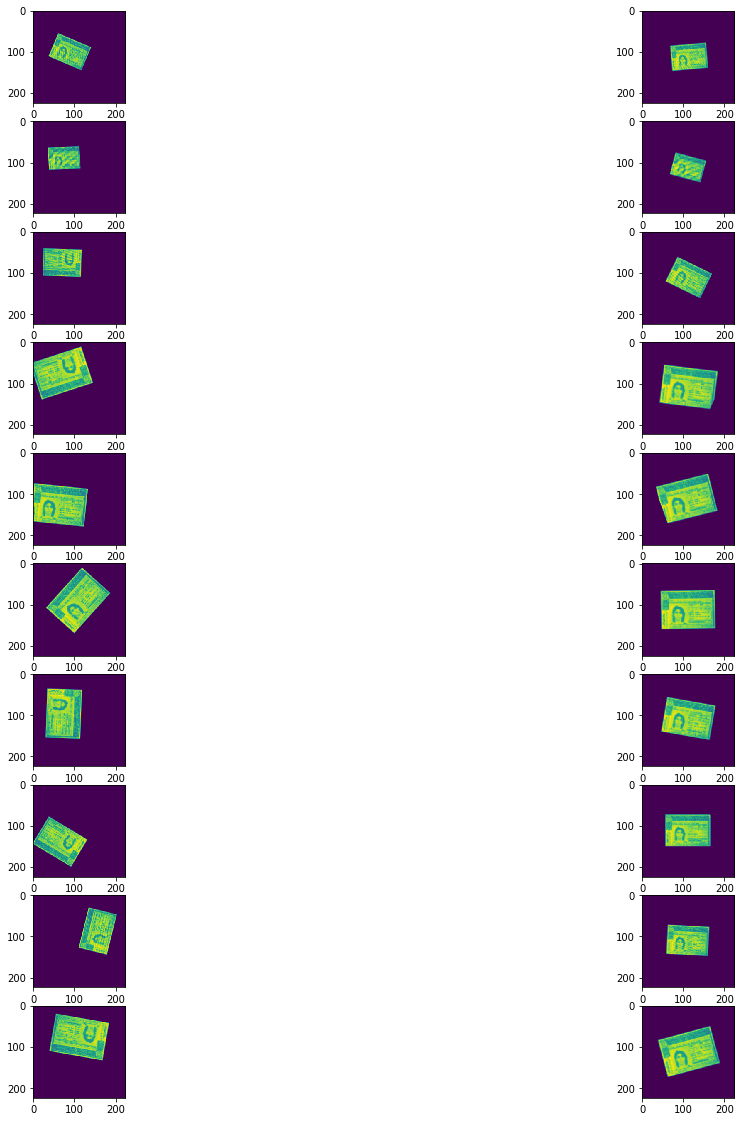

In [17]:
%matplotlib inline
plots = []
fig = plt.figure(figsize=(20,20))
__=0
for i in range(len(final_pred)):
    plots.append(fig.add_subplot(10, 2, __+1))
    plots[__].imshow(test_batch[i].reshape(224,224))
    plots.append(fig.add_subplot(10, 2, __+2))
    plots[__+1].imshow(img_rotate(img_translate(test_batch[i].reshape(224, 224), 1-final_pred[i][1], 1-final_pred[i][2]), -final_pred[i][0]))
    __ += 2
    